# Notebook 3: Model Setup and Evaluation

In this notebook, we will use the dataset prepared in notebook 2 to begin the modelling process to predict restaurant review ratings.

Below is the reminder of the notebook sequence. Please read the notebooks in sequence.

- **Previous Notebook:** NB2-Data_Cleaning_EDA_Feature_Engineering

- **Current Notebook:** NB3-Model_Setup_and_Evaluation


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Read-in-Dataset" data-toc-modified-id="Read-in-Dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Read in Dataset</a></span></li><li><span><a href="#Converting-the-date-Column" data-toc-modified-id="Converting-the-date-Column-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Converting the <code>date</code> Column</a></span></li><li><span><a href="#Get-Dummies" data-toc-modified-id="Get-Dummies-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Get Dummies</a></span></li><li><span><a href="#Ordering-the-columns" data-toc-modified-id="Ordering-the-columns-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Ordering the columns</a></span></li><li><span><a href="#Define-X-and-y" data-toc-modified-id="Define-X-and-y-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Define X and y</a></span></li><li><span><a href="#Checking-Correlation-of-Numeric-Columns-with-Rating" data-toc-modified-id="Checking-Correlation-of-Numeric-Columns-with-Rating-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Checking Correlation of Numeric Columns with Rating</a></span></li><li><span><a href="#Checking-for-Multicollinearity" data-toc-modified-id="Checking-for-Multicollinearity-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Checking for Multicollinearity</a></span></li><li><span><a href="#Sampling-the-Data" data-toc-modified-id="Sampling-the-Data-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Sampling the Data</a></span></li></ul></li><li><span><a href="#Modelling-Setup" data-toc-modified-id="Modelling-Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling Setup</a></span><ul class="toc-item"><li><span><a href="#Defining-Train-and-Test-Sets" data-toc-modified-id="Defining-Train-and-Test-Sets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Defining Train and Test Sets</a></span></li><li><span><a href="#Custom-Scoring-Functions" data-toc-modified-id="Custom-Scoring-Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Custom Scoring Functions</a></span></li><li><span><a href="#Defining-Pipeline-and-Word-Encoding-Transformers" data-toc-modified-id="Defining-Pipeline-and-Word-Encoding-Transformers-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Defining Pipeline and Word Encoding Transformers</a></span></li><li><span><a href="#Dummy-Model" data-toc-modified-id="Dummy-Model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Dummy Model</a></span></li></ul></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#L2-Regularization" data-toc-modified-id="L2-Regularization-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>L2 Regularization</a></span></li><li><span><a href="#L1-Regularization" data-toc-modified-id="L1-Regularization-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>L1 Regularization</a></span></li><li><span><a href="#Pipeline-and-Model-Optimization-Using-GridSearchCV" data-toc-modified-id="Pipeline-and-Model-Optimization-Using-GridSearchCV-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Pipeline and Model Optimization Using GridSearchCV</a></span></li><li><span><a href="#Most-Important-Features" data-toc-modified-id="Most-Important-Features-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Most Important Features</a></span></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>Saving the model</a></span></li><li><span><a href="#N-grams" data-toc-modified-id="N-grams-4.1.6"><span class="toc-item-num">4.1.6&nbsp;&nbsp;</span>N-grams</a></span></li></ul></li><li><span><a href="#Decision-Trees" data-toc-modified-id="Decision-Trees-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Pipeline-and-Model-Optimization-Search" data-toc-modified-id="Pipeline-and-Model-Optimization-Search-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Pipeline and Model Optimization Search</a></span></li></ul></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Gradient-Boost" data-toc-modified-id="Gradient-Boost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Gradient Boost</a></span><ul class="toc-item"><li><span><a href="#Saving-the-Model" data-toc-modified-id="Saving-the-Model-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Saving the Model</a></span></li><li><span><a href="#Using-Optuna" data-toc-modified-id="Using-Optuna-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Using Optuna</a></span></li></ul></li></ul></li><li><span><a href="#Ignore" data-toc-modified-id="Ignore-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ignore</a></span></li><li><span><a href="#Rough-Work" data-toc-modified-id="Rough-Work-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Rough Work</a></span><ul class="toc-item"><li><span><a href="#Optuna" data-toc-modified-id="Optuna-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Optuna</a></span></li></ul></li><li><span><a href="#Word-embeddings" data-toc-modified-id="Word-embeddings-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Word embeddings</a></span></li></ul></div>

## Data Preprocessing

### Import Libraries
We begin by importing all the libraries required to run this notebook. We will use NumPy and Pandas to load in and process our data. We will utilize Matplotlib and Seaborn for visualization. Statitics modules from SciPy and Statsmodels will be utilized. For Natural Language Processing (NLP), we will use NLP tools from Scikit-Learn, NLTK, and Gensim. Finally, for machine learning and hyperparameter tuning, we will use select modules from Scikit-Learn, XGBoost, and Optuna.

In [1]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# SciPy modules
from scipy import stats
from scipy.sparse import csr_matrix

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sklearn modules
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

# XGBooost
from xgboost import XGBRegressor
from xgboost import plot_importance

# Import Optuna
import optuna

# Python string package
import string
import random

# NLTK for NLP purposes
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Gensim for utilizing word embeddings
import gensim
from gensim.utils import simple_preprocess

# Joblib for pickling purposes
import joblib


# Define some default visualizaiton display properties

# Ensure plots are always centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in Dataset

We now read in the review dataset that was prepared and exported in Notebook 2.

In [2]:
df = pd.read_csv('../data/review_data_cleaned.csv')
df.head()

,date,latitude,longitude,average_rating,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,...,Bakeries,Japanese,Delis,Specialty Food,stars,text,reviews_per_week,repeat_customers,number_of_branches,review_length
0,2016-03-07 17:58:53,42.541155,-70.973438,4.0,39,1,1,1,1,1,...,0,0,0,0,4,Pizza here is delicious. I tried it once a few...,0.057097,0,1,62
1,2010-01-10 17:33:51,42.541155,-70.973438,4.0,39,1,1,1,1,1,...,0,0,0,0,4,love this place! really good pizza and probabl...,0.057097,0,1,33
2,2007-12-30 15:51:13,42.541155,-70.973438,4.0,39,1,1,1,1,1,...,0,0,0,0,4,"Go up route one, get off on Lowell street head...",0.057097,0,1,158
3,2016-10-17 22:37:50,42.541155,-70.973438,4.0,39,1,1,1,1,1,...,0,0,0,0,1,Tonight was the first and last time we will or...,0.057097,0,1,117
4,2018-03-09 00:32:31,42.541155,-70.973438,4.0,39,1,1,1,1,1,...,0,0,0,0,5,Salads are actually green and hearty!\nPita po...,0.057097,0,1,24


In [3]:
df.shape

(1364840, 45)

The data frame has 1,364,840 rows and 45 columns.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 45 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   date                        1364840 non-null  object 
 1   latitude                    1364840 non-null  float64
 2   longitude                   1364840 non-null  float64
 3   average_rating              1364840 non-null  float64
 4   review_count                1364840 non-null  int64  
 5   is_open                     1364840 non-null  int64  
 6   RestaurantsGoodForGroups    1364840 non-null  int64  
 7   HasTV                       1364840 non-null  int64  
 8   GoodForKids                 1364840 non-null  int64  
 9   RestaurantsTakeOut          1364840 non-null  int64  
 10  RestaurantsPriceRange2      1364840 non-null  int64  
 11  RestaurantsReservations     1364840 non-null  int64  
 12  RestaurantsAttire           1364840 non-null  object 
 1

We can see that the `date`, `RestaurantsAttire`, `NoiseLevel`, `Alcohol`, `WiFi`, and `text` columns of an `object` data type. We need to preprocess in order to make it compatible with the machine learning models that we will train in this notebook. We will address the `text` column later on in the notebook after defining our training and test sets. Let's begin by addressing the other `object` columns.

### Converting the `date` Column

We can see that the `date` column is of an object data type. It would be more convenient, if we could extract the individual components of the date as separate numeric columns (e.g. year, month, etc., of the review). To do this, we first convert the `date` column to a `datetime` format and then extract the components of interest. 

In [5]:
df['date'] = pd.to_datetime(df['date']) # Convert to datetime
df.insert(loc=0, column='Year', value=df['date'].dt.year) # Extract Year as separate column
df.insert(loc=1, column='Month', value=df['date'].dt.month) # Extract Month as separate 
df.insert(loc=2, column='Day', value=df['date'].dt.day) # Extract the day number as a separate column
df.insert(loc=3, column='Day of Week', value=df['date'].dt.weekday) # Extract the day of week as a separate column
df.insert(loc=4, column='Hour', value=df['date'].dt.hour) # Extract the hour as a seaprate column
df.insert(loc=5, column='Minute', value=df['date'].dt.minute) # Extract the minute as a separate column
df.drop('date', axis=1, inplace=True) # Drop the date column

# Verify
df.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,average_rating,review_count,...,Bakeries,Japanese,Delis,Specialty Food,stars,text,reviews_per_week,repeat_customers,number_of_branches,review_length
0,2016,3,7,0,17,58,42.541155,-70.973438,4.0,39,...,0,0,0,0,4,Pizza here is delicious. I tried it once a few...,0.057097,0,1,62
1,2010,1,10,6,17,33,42.541155,-70.973438,4.0,39,...,0,0,0,0,4,love this place! really good pizza and probabl...,0.057097,0,1,33
2,2007,12,30,6,15,51,42.541155,-70.973438,4.0,39,...,0,0,0,0,4,"Go up route one, get off on Lowell street head...",0.057097,0,1,158
3,2016,10,17,0,22,37,42.541155,-70.973438,4.0,39,...,0,0,0,0,1,Tonight was the first and last time we will or...,0.057097,0,1,117
4,2018,3,9,4,0,32,42.541155,-70.973438,4.0,39,...,0,0,0,0,5,Salads are actually green and hearty!\nPita po...,0.057097,0,1,24


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 50 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   average_rating              1364840 non-null  float64
 9   review_count                1364840 non-null  int64  
 10  is_open                     1364840 non-null  int64  
 11  RestaurantsGoodForGroups    1364840 non-null  int64  
 12  HasTV                       1364840 non-null  int64  
 1

We have successfully converted the date components to separate integer columns.

### Encoding the `NoiseLevel` Column

Let's take a look at the `NoiseLevel` column values. 

In [7]:
df['NoiseLevel'].unique().tolist()

['average', 'quiet', 'loud', 'very_loud']

While `NoiseLevel` is a categorical column, we will employ an ordinal encoding strategy rather than one hot encoding since the values here have a sense of ranking. Hence we will map the noise levels from 1 to 4, with 1 indicating 'average' noise level, and 4 indicating 'very loud'.

In [8]:
df['NoiseLevel'] = df['NoiseLevel'].map({'average': 1, 'quiet': 2, 'loud': 3, 'very_loud': 4})

In [9]:
df['NoiseLevel'].value_counts()

1    1105718
3     130786
2     110007
4      18329
Name: NoiseLevel, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 50 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   average_rating              1364840 non-null  float64
 9   review_count                1364840 non-null  int64  
 10  is_open                     1364840 non-null  int64  
 11  RestaurantsGoodForGroups    1364840 non-null  int64  
 12  HasTV                       1364840 non-null  int64  
 1

The `NoiseLevel` column is now a numeric column.

### One Hot Encoding of Remaining Categorical Variables

We will now proceed to one hot encode the remaining `object` data type columns. We will use Pandas' `get_dummies` method, and we will set its `drop_first` paramter to `True` to prevent multicollinearity in our dataset, since for a given column with $k$ unique mutually exculsive categories, knowing the values of $k-1$ of those category columns will allow us to know the value of the $k$th category column.

In [11]:
# Get  columns whose data type is object, except text column
object_columns = df.drop('text', axis=1).dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'Alcohol', 'WiFi']

In [12]:
# Apply 1-hot encoding to the object columns, dropping the first column
temp_df = pd.get_dummies(df[object_columns], drop_first=True)
temp_df.head()

,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [13]:
# Concatentate the 1 hot encoded columns to the data frame, dropping
# the original object columns from the data frame
df = pd.concat([df.drop(columns = object_columns), temp_df], axis=1)
df.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,average_rating,review_count,...,reviews_per_week,repeat_customers,number_of_branches,review_length,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,2016,3,7,0,17,58,42.541155,-70.973438,4.0,39,...,0.057097,0,1,62,0,0,0,1,0,0
1,2010,1,10,6,17,33,42.541155,-70.973438,4.0,39,...,0.057097,0,1,33,0,0,0,1,0,0
2,2007,12,30,6,15,51,42.541155,-70.973438,4.0,39,...,0.057097,0,1,158,0,0,0,1,0,0
3,2016,10,17,0,22,37,42.541155,-70.973438,4.0,39,...,0.057097,0,1,117,0,0,0,1,0,0
4,2018,3,9,4,0,32,42.541155,-70.973438,4.0,39,...,0.057097,0,1,24,0,0,0,1,0,0


In [14]:
# Move the text column to the last column of the data frame
temp_df = df[['text']]
df = pd.concat([df.drop('text', axis=1), temp_df], axis=1)
df.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,average_rating,review_count,...,repeat_customers,number_of_branches,review_length,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid,text
0,2016,3,7,0,17,58,42.541155,-70.973438,4.0,39,...,0,1,62,0,0,0,1,0,0,Pizza here is delicious. I tried it once a few...
1,2010,1,10,6,17,33,42.541155,-70.973438,4.0,39,...,0,1,33,0,0,0,1,0,0,love this place! really good pizza and probabl...
2,2007,12,30,6,15,51,42.541155,-70.973438,4.0,39,...,0,1,158,0,0,0,1,0,0,"Go up route one, get off on Lowell street head..."
3,2016,10,17,0,22,37,42.541155,-70.973438,4.0,39,...,0,1,117,0,0,0,1,0,0,Tonight was the first and last time we will or...
4,2018,3,9,4,0,32,42.541155,-70.973438,4.0,39,...,0,1,24,0,0,0,1,0,0,Salads are actually green and hearty!\nPita po...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 53 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   average_rating              1364840 non-null  float64
 9   review_count                1364840 non-null  int64  
 10  is_open                     1364840 non-null  int64  
 11  RestaurantsGoodForGroups    1364840 non-null  int64  
 12  HasTV                       1364840 non-null  int64  
 1

We have successfully encoded the `object` columns. Note that the `text` column was moved to the last column position - this will be useful when we apply Scikit-Learn's `ColumnTransformer` to vectorize the `text` column.

### Define X and y

We are now ready to define our independent variable array `X` and our dependent variable `y`. Our dependent variable is the number of stars (i.e. the `stars` column).

In [16]:
X = df.drop(['stars'], axis=1)
X.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,average_rating,review_count,...,repeat_customers,number_of_branches,review_length,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid,text
0,2016,3,7,0,17,58,42.541155,-70.973438,4.0,39,...,0,1,62,0,0,0,1,0,0,Pizza here is delicious. I tried it once a few...
1,2010,1,10,6,17,33,42.541155,-70.973438,4.0,39,...,0,1,33,0,0,0,1,0,0,love this place! really good pizza and probabl...
2,2007,12,30,6,15,51,42.541155,-70.973438,4.0,39,...,0,1,158,0,0,0,1,0,0,"Go up route one, get off on Lowell street head..."
3,2016,10,17,0,22,37,42.541155,-70.973438,4.0,39,...,0,1,117,0,0,0,1,0,0,Tonight was the first and last time we will or...
4,2018,3,9,4,0,32,42.541155,-70.973438,4.0,39,...,0,1,24,0,0,0,1,0,0,Salads are actually green and hearty!\nPita po...


In [17]:
y = df['stars']
y.head()

0    4
1    4
2    4
3    1
4    5
Name: stars, dtype: int64

We will now view the distribution of our dependent variable.

In [18]:
def plot_y_distribution(y, title):
    '''
    Displays a bar plot of the distribution
    of the review ratings
    
    PARAMETERS:
    - y (pd.Series): Dependent variable, i.e. review ratings
    
    RETURNS:
    -  None
    
    '''
    
    
    plt.figure(figsize=(15,5))
    plt.bar(y.value_counts().sort_index().index.astype('str'),
            y.value_counts().sort_index())
    plt.title(title, fontsize=20)
    plt.xlabel('stars')
    plt.ylabel('Counts')

    axes = plt.gca()
    axes.set_axisbelow(True)
    
    # Get the y ticks and calculate the intervals between them
    locs, _ = plt.yticks()
    interval = (locs[-1] - locs[0])/(len(locs)-1)

    # Display the data labels above each bar
    for i, j in enumerate(y.value_counts().sort_index()):
        axes.text(i-0.15, j+interval*0.05, str(round(j/y.shape[0]*100,2))+'%',
                  color='royalblue', fontweight='bold')

    # Format the y axis display
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    axes.yaxis.set_major_formatter(tick) 

    plt.show()

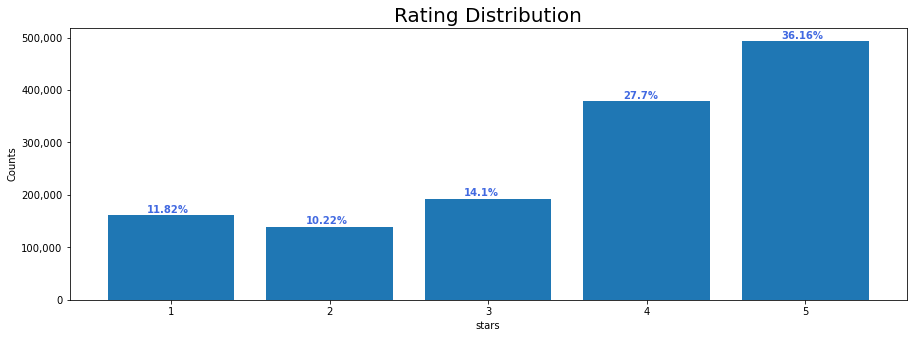

In [19]:
plot_y_distribution(y, 'Rating Distribution')

Our distribution is left skewed. However, we do have a reasonable number of reviews across all the possible number of stars.

### Checking Correlation of Numeric Columns with Rating

We will now look at the pearson-r correlation coefficient for each of our numeric columns and the dependent variable, and the associate p-value for each correlation. We will define a function `correlation_coeff` that returns a dataframe listing each variable with its correlation coefficient with the dependent variable and the associated p-value. For each variable, our null hypothesis $H_o$ states that there is no correlation between the variable and the dependent variable. We will use a p-value threshold of 5%, meaning that if we have a p-value less than 0.05, our correlation is statistically significant and we can reject the null hypothesis.

In [20]:
correlation_df = pd.DataFrame(columns=['Variable', 'Correlation Coefficient', 'p-value'])

for column in X.drop('text', axis=1).columns:
    corr_coef, p_value = stats.pearsonr(X[column], y)
    correlation_df = correlation_df.append({'Variable': column,
                                            'Correlation Coefficient': corr_coef,
                                            'p-value': p_value}, ignore_index=True)
    correlation_df.sort_values(by='p-value', ascending=False, inplace=True)
    
correlation_df

,Variable,Correlation Coefficient,p-value
0,Day,0.000464,5.878830e-01
1,Minute,-0.000980,2.524647e-01
2,longitude,0.001961,2.198227e-02
3,GoodForKids,0.002975,5.091648e-04
4,OutdoorSeating,-0.004986,5.697669e-09
5,Salad,0.005149,1.792507e-09
6,Month,-0.005621,5.155104e-11
7,latitude,0.006700,4.961500e-15
8,WiFi_no,0.008080,3.728531e-21
9,RestaurantsAttire_dressy,0.009331,1.134290e-27


We can see that the `Day` and `Minute` columns not only have low correlation coefficients, but more importantly they have p-values greater than 0.05. This indicates that the correlation between `Day` and `Minute` is not statistically signficiant, and hence we cannot reject the null hypothesis. Let us look make scatter plots against the dependent variable for each of these columns.

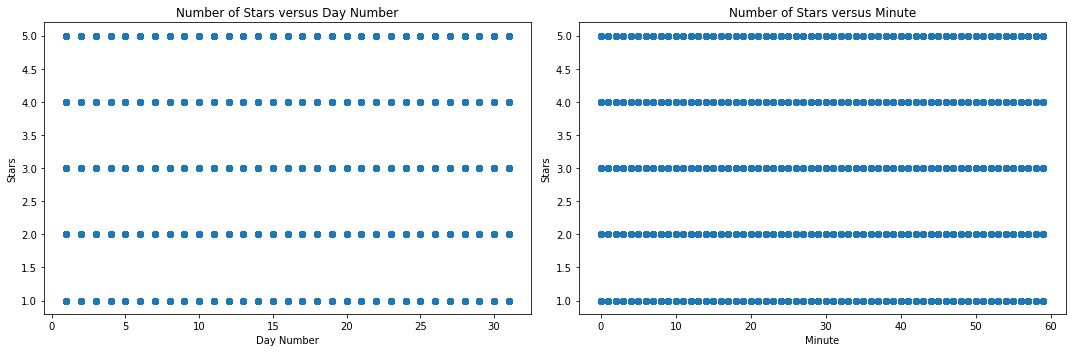

In [21]:
plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1, 2, 1)
plt.scatter(X['Day'], y, alpha=0.1)
plt.title('Number of Stars versus Day Number')
plt.xlabel('Day Number')
plt.ylabel('Stars')

plt.subplot(1, 2, 2)
plt.scatter(X['Minute'], y, alpha=0.1)
plt.title('Number of Stars versus Minute')
plt.xlabel('Minute')
plt.ylabel('Stars')

plt.tight_layout()
plt.show()

As we can see, there does not appear to be any correlation between the day number nor the minute with the number of stars.

While a the Pearson-r correlation coefficient can only detect linear relationships between two variables, and although we might choose to explore non-linear models like tree-based models, we will drop the `Day` and `Minute` column.

In [22]:
X.drop(['Day', 'Minute'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 50 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day of Week                 1364840 non-null  int64  
 3   Hour                        1364840 non-null  int64  
 4   latitude                    1364840 non-null  float64
 5   longitude                   1364840 non-null  float64
 6   average_rating              1364840 non-null  float64
 7   review_count                1364840 non-null  int64  
 8   is_open                     1364840 non-null  int64  
 9   RestaurantsGoodForGroups    1364840 non-null  int64  
 10  HasTV                       1364840 non-null  int64  
 11  GoodForKids                 1364840 non-null  int64  
 12  RestaurantsTakeOut          1364840 non-null  int64  
 1

### Checking for Multicollinearity

We now should take a look at whether there are correlations between the different independent variables to avoid multicollinearity. We will plot a correlation matrix heatmap our independent variables. Since we may plot this heatmap more than once, we will define a function that will plot the heatmap and print a data frame showing the Pearson correlation coefficients and the associated p-values between column pairs that exceed a threshold. We will choose to examine column pairs that have a threshold greater than 0.7.

In [23]:
def corr_matrix_heatmap(X, threshold):
    '''
    Displays the correlation matrix heatmap and prints the 
    Pearson correlation coefficient and the associated p-value
    between column pairs that have a correlation coefficient
    greater than the threshold
    
    PARAMETERS:
    - X (pd.DataFrame): Data frame to analyze
    - threshold (float): The correlation coefficient threshold
    
    RETURNS:
    -  None
    
    '''
    plt.figure(figsize=(20,15)) # set plot size
    corr_matrix=X.corr() #retrieve correlation matrix
    
    flag = 0 # initialize flag
       
    mask = np.triu(np.ones_like(corr_matrix)) 

    # plot heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask, vmin=-1, vmax=1) 
    plt.show()
    
    # Initialize dataframe for column pairs that exceed threshold
    multicollinear_df = pd.DataFrame(columns=['variable1', 'variable2',
                                              'corr_coeff', 'p-value'])

    i=0
    for col in corr_matrix.columns:
        for j in range(i+1, len(corr_matrix[col])):

            if corr_matrix.iloc[j, i] > threshold:
                # If column pair exceeds correlation threshold
                # set flag to 1 and append pair to data frame
                flag = 1
                multicollinear_df = multicollinear_df.append({'variable1': col,
                                                        'variable2': corr_matrix.index[j],
                                                        'corr_coeff': corr_matrix.iloc[j, i],
                                                        'p-value': stats.pearsonr(X[col], X[corr_matrix.index[j]])[1]},
                                                        ignore_index=True)

        i+=1
    # Sort by correlation coefficient, descending order
    multicollinear_df = multicollinear_df.sort_values(by='corr_coeff', ascending=False).reset_index(drop=True)
    
    if flag == 1:
        print(multicollinear_df)
        
    else:
        print('Correlations between independent variables less than or equal to threshold.')

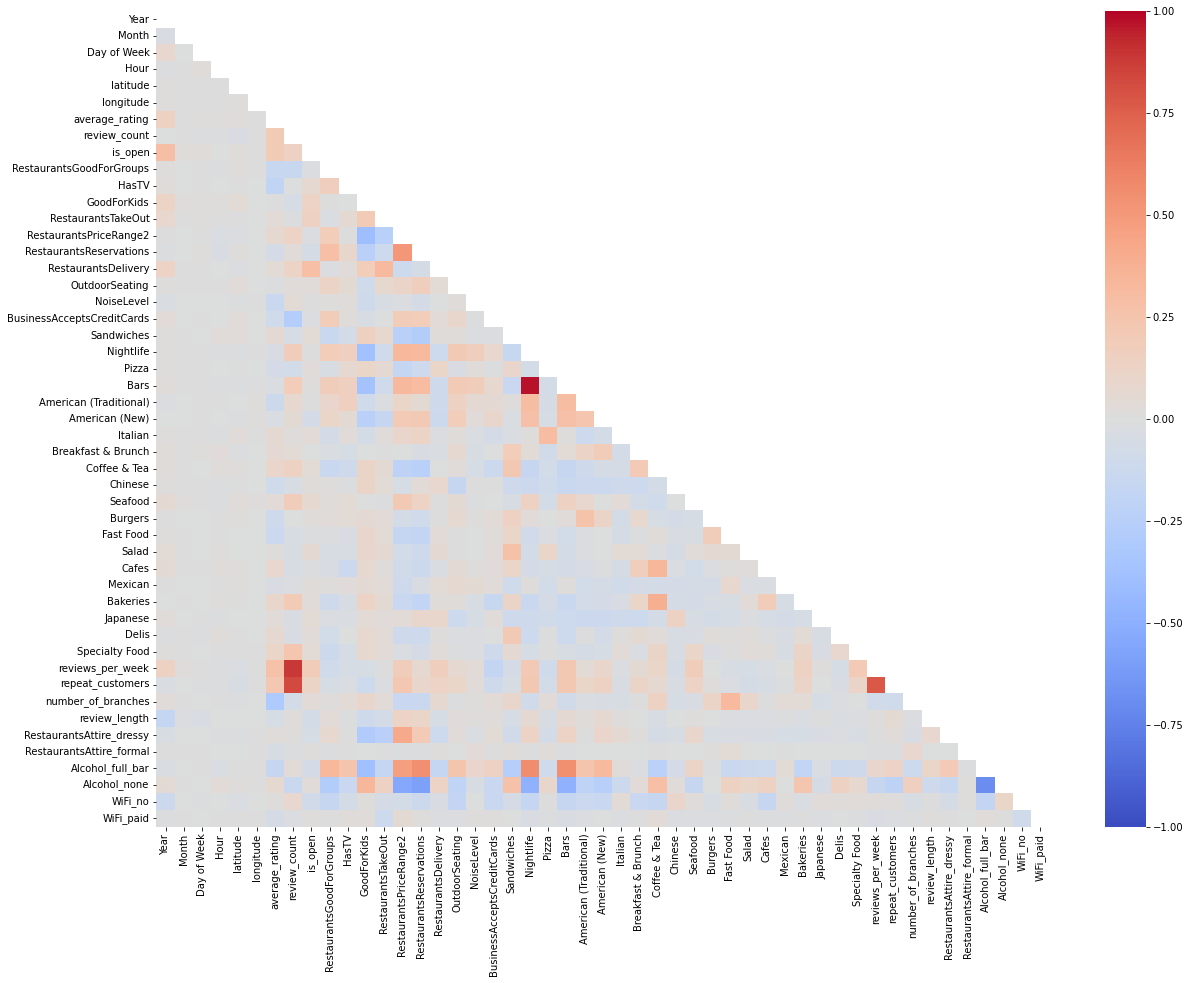

          variable1         variable2  corr_coeff  p-value
0         Nightlife              Bars    0.975627      0.0
1      review_count  reviews_per_week    0.888053      0.0
2      review_count  repeat_customers    0.833642      0.0
3  reviews_per_week  repeat_customers    0.780378      0.0


In [24]:
corr_matrix_heatmap(X, 0.7)

We can see that `Bars` and `Nightlife` are highlighly correlated with each other (correlattion coefficient = 0.98). These are both binary columns so it makes sense to compare both of them. I will drop the `Nightlife` column here since intuitively it makes sense that restaurants described as `Bars` are likely open in the night and hence may alos be classified under the `Nightlife` category.

We will also drop `review_count` as it is highly correlated with both `reviews_per_week` and `repeat_customers`. Finally, we will also drop `reviews_per_week` as it is highly correlated with `repeat_customers`.

Note that looking at the p-values, all of these correlations are statistically significant.

In [25]:
# Drop indep. variables that are highly correlated with other indep. variables

X.drop(['Nightlife', 'review_count', 'reviews_per_week'], axis=1, inplace=True)

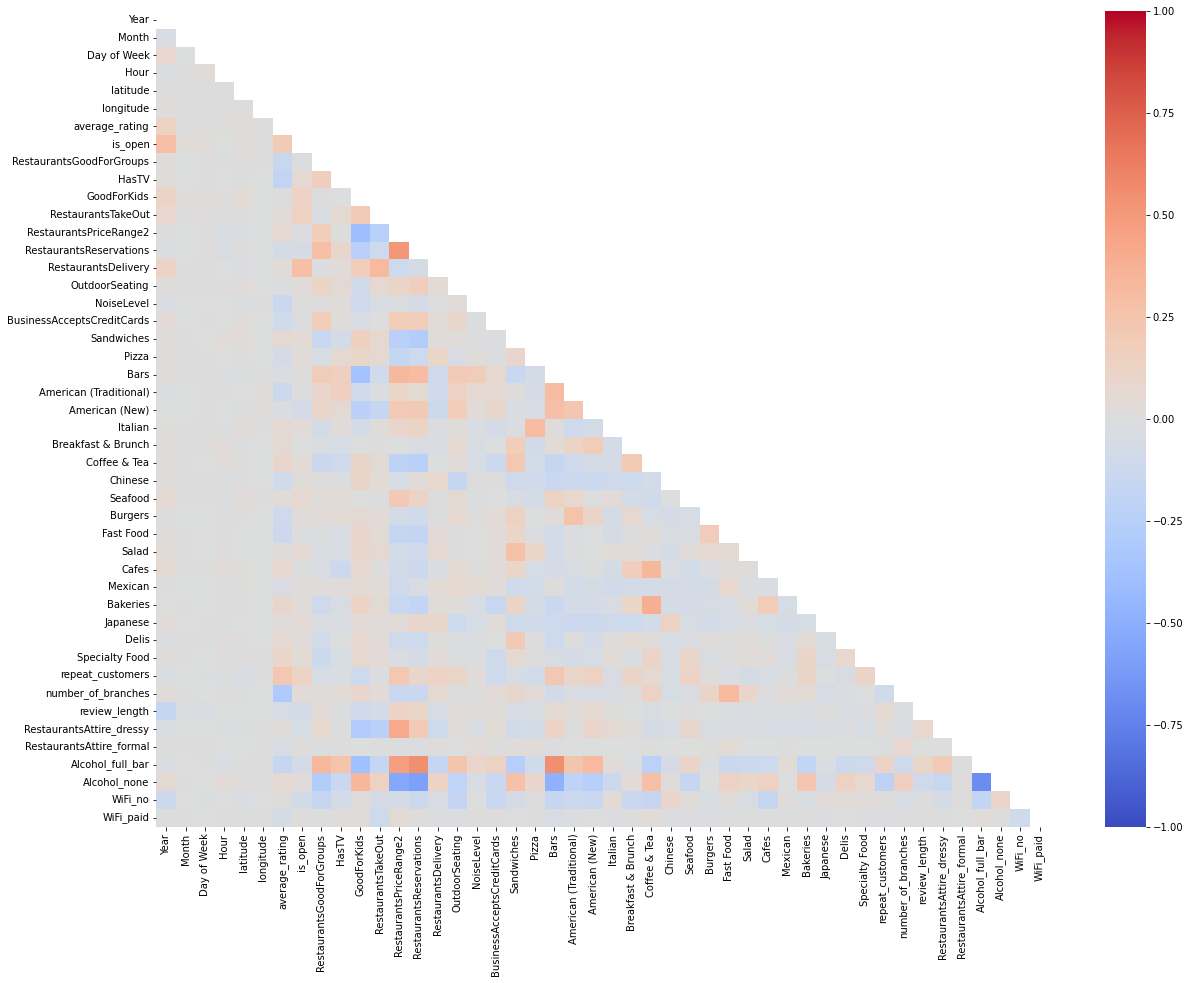

Correlations between independent variables less than or equal to threshold.


In [26]:
corr_matrix_heatmap(X, 0.7)

We now no longer have an correlations between independent variables that exceed our threshold.

## Modelling Setup

### Sampling the Data

Due to the large dataset (1.3 million reviews) which includes text data, and computing hardware limitations, we will subsample our dataset so that the dataset is more manageable more model training and evaluation. We will use the `resample` method from Scikit-Learn, sampling without replacement, and stratifying based on y. For this project, we will utilize around 13,000 reviews (~1% of the original dataset).

In [27]:
X_sampled, y_sampled = resample(X, y, random_state=0, 
                                    n_samples = 0.01*X.shape[0],
                                    replace=False, stratify=y)

In [28]:
print(f'X_sampled shape: {X_sampled.shape}')
print(f'y_sampled shape: {y_sampled.shape}')

X_sampled shape: (13648, 47)
y_sampled shape: (13648,)


Our sampled dataset has 13,648 rows and 47 columns. Let's take a look at the distribution of our dependent variable in this sample.

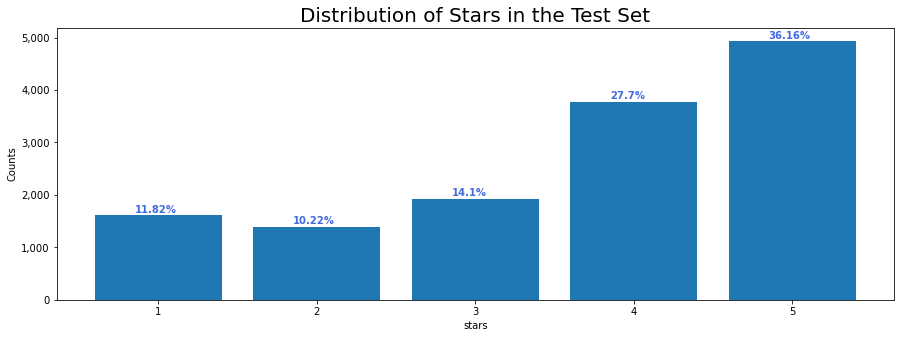

In [29]:
plt.figure(figsize=(15,5))
plt.bar(y_sampled.value_counts().sort_index().index.astype('str'),
        y_sampled.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set', fontsize=20)
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_sampled.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_sampled.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axes.yaxis.set_major_formatter(tick) 

plt.show()

The stratification worked as intended, since our dependent variable distribution in this sample is very similar to its distribution in the overall dataset.

In [237]:
len(X_sampled['latitude'].unique())

4902

### Defining Train and Test Sets

We begin model setup by defining our train and test sets. Note that since we have a relatively smaller dataset to work with (13k rows), we should make sure to leave enough samples in our test set to avoid overfitting to the train set. Hence we will opt for an 80% train - 20% test split.

In [30]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size = 0.2, stratify=y_sampled, random_state=0)


print(f'Shape of X_train: {X_train.shape}. Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shape of y_test: {y_test.shape}')

Shape of X_train: (10918, 47). Shape of y_train: (10918,)
Shape of X_test: (2730, 47). Shape of y_test: (2730,)


Let's visualize the distributions of our dependent variable from both train and test sets, to ensure we have similar distributions to our original dataset.

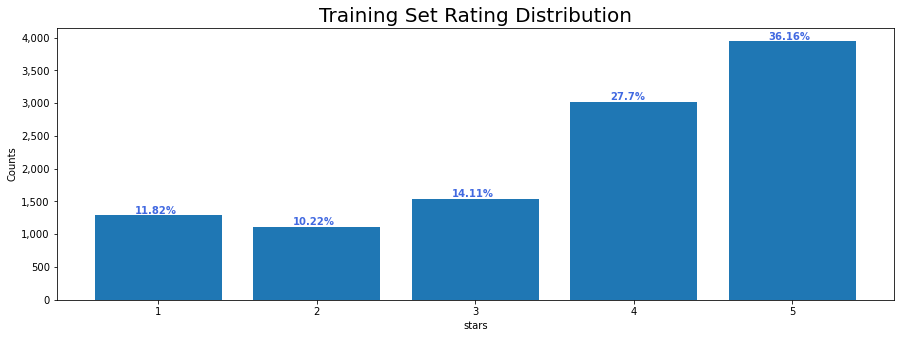

In [31]:
plot_y_distribution(y_train, 'Training Set Rating Distribution')

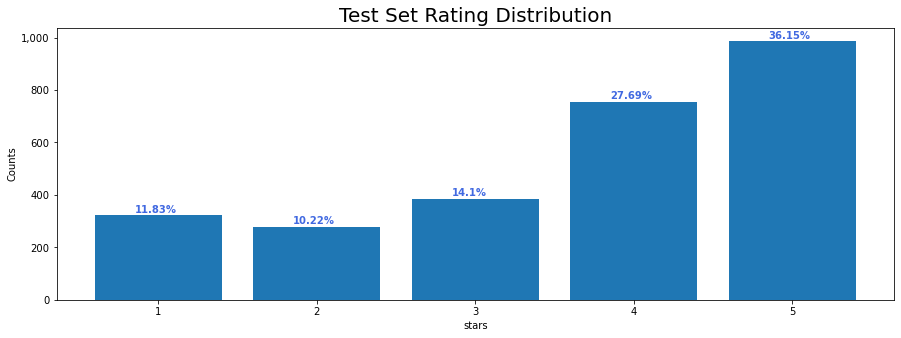

In [32]:
plot_y_distribution(y_test, 'Test Set Rating Distribution')

We see no major difference between the distributions of the dependent variable in both train and test sets when compared to the original dataset. 

### Custom Scoring Functions

Some regression models such as linear regression can make predictions which are lower or greater than the values present in the dataset. Since we know our ratings cannot be below 1 stars nor can they be greater than 5 stars, we need to define a custom function called `bound_predict` that sets a bound on all predictions to within the allowed range. In addition, we need to define custom scorer functions to ensure that Scikit-Learn models such as `cross_validate` and `GridSearchCV` will apply the `bound_predict` method to each model's predictions before calculating the appropriate score. We will pick the model with the best mean absolute error, but we will also monitor the $R^{2}$ score as well to evaluate the quality of the model's fit.

In [33]:
def bound_predict(y_pred):
    '''
    Limits the predicted y values to stay within the range of 1 to 5.
    Predictions less than 1 will be reassigned to a prediction of 1.
    Predictions greater than 5 will be reassigned to a prediction of 5.
    
    PARAMETERS:
    - y_pred (pd.Series): Predicted y values
    
    RETURNS:
    - y_pred (pd.Series): Predicted y values no less than 1 nor greater than 5
    
    '''
    y_pred = np.where(y_pred > 5, 5, y_pred)
    y_pred = np.where(y_pred < 1, 1, y_pred)
    return y_pred

Let's test this function to ensure it works as intended.

In [34]:
# Test functionality of bound_predict()
bound_predict(np.array([1,0,4,7,0.6]))

array([1., 1., 4., 5., 1.])

The `bound_predict` function works. We will now define our custom scorer functions that will call `bound_predict` on the true y values and the predicted y values before calling Scikit-Learn's `mean_absolute_error` and `r2_score` metrics. The scorer functions will then be made scorers using Scikit-Learn's `make_scorer` function for use in modules like `cross_validate`, `cross_val_score`, `GridSearchCV`, etc.

In [35]:
def custom_mae_scorer_func(y_true, y_pred):
    '''
    Customer mean absolute error scorer function.
    Limits the predicted values to remain with 1 to 5
    using the bound_predict function. Returns Sklearn's mean_absolute_error
    metric on the bound predictions and the true y values.
    
    PARAMETERS:
    - y_true (pd.Series): True y values
    - y_pred (pd.Series): Predicted y values
    
    RETURNS:
    - mean_absolute_error(y_true, y_pred): float, mean absolute error
    of the true y values and the bound predicted y values
    
    '''

    y_pred = bound_predict(y_pred)
    return mean_absolute_error(y_true, y_pred)

def custom_r2_scorer_func(y_true, y_pred):
    '''
    Customer R-squared scorer function.
    Limits the predicted values to remain with 1 to 5
    using the bound_predict function. Returns Sklearn's r2_score
    metric on the bound predictions and the true y values.
    
    PARAMETERS:
    - y_true (pd.Series): True y values
    - y_pred (pd.Series): Predicted y values
    
    RETURNS:
    - r2_score(y_true, y_pred): float, R-squared score
    of the true y values and the bound predicted y values
    
    '''
    y_pred = bound_predict(y_pred)
    return r2_score(y_true, y_pred)

# Define custom sklearn scorer functions using make_scorer and the 
# custom scorer functions
custom_mae_scorer = make_scorer(custom_mae_scorer_func, greater_is_better=False)
custom_r2_scorer = make_scorer(custom_r2_scorer_func, greater_is_better=True)

# Pass the custom scorers to a scoring dictionary
scorer = {'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
          'custom_r2_scorer': make_scorer(custom_r2_scorer_func, greater_is_better=True)}

### Defining Pipeline and Word Encoding Transformers

We now need to process our `text` column. We will need to apply a column transformer that ignores the numeric columns, than encodes the `text` either via a count vectorizer, TF-IDF vectorizer, or word embedding vectorizer.

First, let us append all our numeric columns to a list.

In [36]:
numeric_columns = X_train.dtypes[df.dtypes != 'object'].index.to_list()
numeric_columns

['Year',
 'Month',
 'Day of Week',
 'Hour',
 'latitude',
 'longitude',
 'average_rating',
 'is_open',
 'RestaurantsGoodForGroups',
 'HasTV',
 'GoodForKids',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'NoiseLevel',
 'BusinessAcceptsCreditCards',
 'Sandwiches',
 'Pizza',
 'Bars',
 'American (Traditional)',
 'American (New)',
 'Italian',
 'Breakfast & Brunch',
 'Coffee & Tea',
 'Chinese',
 'Seafood',
 'Burgers',
 'Fast Food',
 'Salad',
 'Cafes',
 'Mexican',
 'Bakeries',
 'Japanese',
 'Delis',
 'Specialty Food',
 'repeat_customers',
 'number_of_branches',
 'review_length',
 'RestaurantsAttire_dressy',
 'RestaurantsAttire_formal',
 'Alcohol_full_bar',
 'Alcohol_none',
 'WiFi_no',
 'WiFi_paid']

When exploring count vectorizer and TF-IDF vectorizers, we will also explore the impact of applying stemming or lemmatization tokenizers within those vectorizers. In the code block below, we define our stemming and lemmatization tokenizers. We will use NLTK's PorterStemmer and WordNetLemmatizer modules for stemming and lemmatization respectively. Each tokenizer will remove English stop words as well.

In [37]:
ENGLISH_STOP_WORDS = stopwords.words('english')

def tokenizer_prep(sentence):
    '''
    Returns list of words from a string with all punctuation removed.
    
    PARAMETERS:
    - sentence: str, input text.
    
    RETURNS:
    - listofwords: list, list of substring in the input text,
    excluding punctuation, separated by whitespace.
    
    '''
    # remove punctuation and set to lower case
    # english_stop_words = stopwords.words('english')
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    return listofwords


def tokenizer_stemming(sentence):
    '''
    Returns list of stemmed tokens from an input string.
    
    PARAMETERS:
    - sentence: str, input text.
    
    RETURNS:
    - listofstemmed_words: list, list of stemmed tokens 
    from input string
    
    '''
    stemmer = PorterStemmer()
    listofwords = tokenizer_prep(sentence) 
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

def tokenizer_lemmatizer(sentence):
    '''
    Returns list of lemmatized tokens from an input string.
    
    PARAMETERS:
    - sentence: str, input text.
    
    RETURNS:
    - listoflemmatized_words: list, list of lemmatized tokens 
    from input string
    
    '''
    lemmatizer = WordNetLemmatizer()
    listofwords = tokenizer_prep(sentence) 
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lematized words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words


Let us test the tokenizers.

In [38]:
random.seed(10)
i = random.choice(X_train.index)
review = X_train.loc[i, 'text']


In [39]:
print(review)
print('\n')
print(tokenizer_stemming(review))

For the first several bites the dishes taste really good. But due to their excessively use of Monosodium Glutamate I felt really thirsty afterwards.


['first', 'sever', 'bite', 'dish', 'tast', 'realli', 'good', 'due', 'excess', 'use', 'monosodium', 'glutam', 'felt', 'realli', 'thirsti', 'afterward']


In [40]:
print(review)
print('\n')
print(tokenizer_lemmatizer(review))

For the first several bites the dishes taste really good. But due to their excessively use of Monosodium Glutamate I felt really thirsty afterwards.


['first', 'several', 'bite', 'dish', 'taste', 'really', 'good', 'due', 'excessively', 'use', 'monosodium', 'glutamate', 'felt', 'really', 'thirsty', 'afterwards']


It looks like our stemming and lemmatization tokenizers work.

Since we need to define 4 column transformers, we will define a function `define_col_trans` that creates a column transformer given our choice of text vectorizer. 

Note that both `CountVectorizer` and `TfidfVectorizer` return a sparse matrix. Having said that, we will need to scale our data after applying the column transformers to ensure our features are of similar scale, but Scikit-Learn's scalers like `StandardScaler` and `MinMaxScaler` require a dense array as an input. Hence we define another helper function called `convert_to_array` which takes in a sparse matrix and converts it into a dense array. We need to to pass it through a `FunctionTransformer` in our pipeline, which will take the sparse matrix output from the column transformer and convert it a dense array before feeding into our scaler.

In [41]:
def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    
    col_trans = ColumnTransformer([
        ('numeric', 'passthrough', numeric_columns),
        (input_text, vectorizer, 'text')
    ])
    
    return col_trans

In [42]:
def convert_to_array(sparse_matrix):
    '''
    Converts sparse matrix to dense array
    
    PARAMETERS:
    - sparse_matrix: scipy.sparse.csr_matrix or numpy array
    
    RETURNS:
    - If sparse_matrix is not a scipy.sparse.csr_matrix,
      sparse_matrix is returned. Else, returns the dense array
      form of sparse_matrix.
    
    '''
    
    if type(sparse_matrix) == csr_matrix:
    
        return sparse_matrix.toarray()
    
    else:
        return sparse_matrix

We are now ready to define our column transformers. Recall that we will be create 4 unique columns transformers:
1. Bag of Words vectorizer with stemming, denoted as `bow_stem_ct`
2. Bag of Words vectorizer with lemmatization, denoted as `bow_lem_ct`
3. TF-IDF vectorizer with stemming, denoted as `tfidf_stem_ct`
4. TF-IDF vectorizer with lemmatization, denoted as `tfidf_lem_ct`

We will also set each vectorizer's `max_features` parameter to 3000. This will force the vectorizers to consider the top 3000 features ordered by term frequency across the corpus, and will keep our dataset size manageable for machine learning on my local machine.

In [43]:
bow_stem_ct = define_col_trans('bow_stem_ct', CountVectorizer(tokenizer=tokenizer_stemming, max_features=3000, ngram_range=(1,2)))
bow_lem_ct = define_col_trans('bow_lem_ct', CountVectorizer(tokenizer=tokenizer_lemmatizer, max_features=3000, ngram_range=(1,2)))
tfidf_stem_ct = define_col_trans('tfidf_stem_ct', TfidfVectorizer(tokenizer=tokenizer_stemming, max_features=3000, ngram_range=(1,2)))
tfidf_lem_ct = define_col_trans('tfidf_lem_ct', TfidfVectorizer(tokenizer=tokenizer_lemmatizer, max_features=3000, ngram_range=(1,2)))
# sent2vec = define_col_trans('sent2vec', FunctionTransformer(sent2vec_col_trans))

vectorizer_list = [bow_stem_ct, bow_lem_ct, tfidf_stem_ct, tfidf_lem_ct]

Let's fit this transformer to the training set to confirm if the shape is what we expect. Recall that we also have 46 numeric columns so we should see a shape of 3,046 columns after fitting.

In [44]:
%%time

print(f'Shape of X_train using bag of words with stemming: {bow_stem_ct.fit_transform(X_train).shape}')
print(f'Shape of X_train using bag of words with lemmatization: {bow_lem_ct.fit_transform(X_train).shape}')
# print(f'Shape of X_train using word embeddings: {sent2vec.fit_transform(X_train).shape}')


Shape of X_train using bag of words with stemming: (10918, 3046)
Shape of X_train using bag of words with lemmatization: (10918, 3046)
CPU times: user 20.6 s, sys: 199 ms, total: 20.8 s
Wall time: 20.8 s


## Model Evaluation

### Model 0: Baseline Model

Before exploring any machine learning models, we will first define a simple baseline model, that simply always predict the mean rating of the test set, and measure the mean absolute error and $R^{2}$ score on test set as our initial benchmark. We will save the results to a data frame.

In [45]:
baseline_dict = {'model': ['Mean Predictor'],
                 'vectorizer': ['N/A'],
                 'MAE': [custom_mae_scorer_func(y_test, pd.Series([y_test.mean()] * y_test.shape[0]))],
                 'R-squared': [custom_r2_scorer_func(y_test, pd.Series([y_test.mean()] * y_test.shape[0]))]}
                          

overall_results_df = pd.DataFrame(data=baseline_dict)
overall_results_df

,model,vectorizer,MAE,R-squared
0,Mean Predictor,N/A,1.155734,0.0


By simply predicted the mean rating of the test set, we end up with a MAE of 1.16, and an $R^{2}$ of 0.

Since we're going to be evaluating scores of many models, let's define another function that prints the MAE and $R^{2}$ score on both train and test sets. The function will have an optional argument that displays test set residual plots, which can also help us understand the quality of each model.

In [225]:
def model_results(estimator, X_train, y_train, X_test, y_test, show_plots=False):
    '''
    Prints the mean absolute error and R-squared score
    for both training and test sets. Displays residual plots
    if show_plots==True
    
    PARAMETERS:
    - estimator: Sklearn estimator. Estimator must already be fitted!
    - X_train: Pandas data frame or Numpy array representing train set independent variables
    - y_train: Pandas series or Numpy array representing train set dependent variable
    - X_test: Pandas data frame or Numpy array representing test set independent variables
    - y_test: Pandas series or Numpy array representing test set dependent variable
    - show_plots: Boolean
    
    RETURNS:
    - None
    
    '''
    # Calculate predicted value and residual on train set
    fitted_values_train = bound_predict(estimator.predict(X_train))
    residuals_train = y_train - fitted_values_train
    
    print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values_train),2)} stars')
    print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values_train),2)}')

    print('\n')
    
    # Calculate predicted value and residual on test set
    fitted_values_test = bound_predict(estimator.predict(X_test))
    residuals_test = y_test - fitted_values_test
    print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values_test),2)} stars')
    print(f'R^2 on test set: {round(custom_r2_scorer_func(y_test, fitted_values_test),2)}')   
    
    if show_plots == True:
        
        # Display plot of residuals vs. fitted values on test set
        plt.figure()
        sns.regplot(x=fitted_values_test, y=residuals_test, lowess=True, line_kws={'color': 'red'})
        plt.axline(xy1=(1,0), xy2=(5,-4), color='black', label='Lower Prediction Limit')
        plt.axline(xy1=(1,4), xy2=(5,0), color='orange', label='Upper Prediction Limit')
        plt.title('Residuals Versus Fitted Values on Test Set')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.legend()
        plt.savefig('residual.png', dpi=300)
        plt.show()

        # Display histogram of residuals
        plt.figure()
        plt.hist(residuals_test, bins=30)
        plt.title('Residual Distribution on Test Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.savefig('distribution.png', dpi=300)
        plt.show()

        # Display residuals QQ plot on test set
        sm.ProbPlot(residuals_test).qqplot(line='s')
        plt.title('Q-Q Plot ')
        plt.savefig('qqplot.png', dpi=300)
        plt.show()
    


### Model 1: Linear Regression



We begin by exploring Linear Regression. We will explore Linear Regression without regularization, with L2 regularization (i.e. Ridge Regression), and with L1 regularization (i.e. Lasso Regression). 

### Model 1: No Regularization

First we fit a bag of words vectorizer with lemmatization to a linear regression model without regularization.

In [47]:
%%time

noreg_linreg_pipeline = Pipeline([
    ('col_trans', bow_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

noreg_linreg_pipeline.fit(X_train, y_train)

CPU times: user 1min 31s, sys: 4.44 s, total: 1min 35s
Wall time: 22.7 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month',
                                                   'Day of Week', 'Hour',
                                                   'latitude', 'longitude',
                                                   'average_rating', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
      

Let's evaluate our model by displaying both MAE and $R^{2}$ scores on train and test sets.

In [48]:
model_results(noreg_linreg_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.54 stars
R^2 on train set 0.73


MAE on test set: 0.74 stars
R^2 on test set: 0.49


Without any regularization, we have an MAE of 0.54 stars on our train set and 0.74 stars on our test set.
Note the low MAE on the train set and high $R^{2}$ on the train set, and the difference of these scores between training and test sets. This suggests that we are likely overfitting to our training set, hence exploring regularization is a logical next step to help reduce overfitting.


#### Model 1: L2 Regularization

We now fit a Ridge Regression model. Ridge Regression adds the following regularization term during training, which utilizes the $l_2$ norm:

$$P(\beta) = \alpha \sum_i \beta_i ^2$$

Note the hyperparameter $\alpha$ controls the amount of regularization. We will tune this hyerparameter on a bag of words vectorizer with lemmatization, using K-fold cross validation. Note throughout the notebook, when doing cross validation, we fit a full pipeline of vectorizing and value scaling to the training set of **each fold**. This will prevent data leakage as the transformers will be fit to the training set only, and will be then used to transform the training and validation sets after fitting. This ensures that the validation set is truly acting as a simulation of unseen data, similar to how the test set will be treated after picking our parameters of interest and fitting the model to the training set.

**NOTE the code block below may take a few minutes to run. Hence a pickle file of a data frame with the cross validation scores for each $\alpha$ value has been loaded. If refitting the model is desired, set `l2_flag` to 0.**

In [49]:
%%time

# set flag to 0 if model re-fitting is desired
l2_flag = 1

if l2_flag == 1:
    scores = joblib.load('l2_scores.pkl')
    
else:

    scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

    pipeline = Pipeline([
        ('col_trans', bow_lem_ct),
        ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('min-max-scaler', MinMaxScaler()),
        ('model', Ridge())
    ])

    for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:

        cv_scores = cross_validate(pipeline.set_params(**{'model__alpha':alpha}), X_train, y_train, cv=5,
                                   scoring=scorer)

        scores = scores.append({'alpha': alpha,
                                'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])},
                                ignore_index=True)
        
    joblib.dump(scores, 'l2_scores.pkl')
        
    
    
scores

CPU times: user 20.6 ms, sys: 5.44 ms, total: 26.1 ms
Wall time: 3.16 ms


,alpha,MAE,R-squared
0,0.0001,0.764252,0.456536
1,0.0010,0.764166,0.456673
2,0.0100,0.763359,0.457966
3,0.1000,0.757183,0.468350
4,1.0000,0.728962,0.513855
5,10.0000,0.701749,0.563140
6,100.0000,0.783386,0.487092
7,1000.0000,1.002520,0.216091


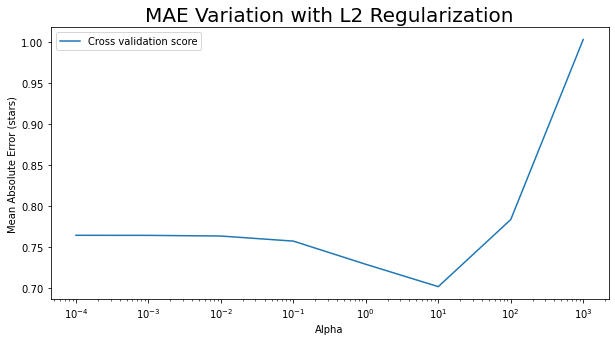

In [50]:
plt.figure(figsize=(10,5))
plt.plot(scores['alpha'], scores['MAE'], label='Cross validation score')
plt.title('MAE Variation with L2 Regularization', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (stars)')
plt.xscale('log')
plt.legend()
plt.show()

We can see that we have the lowest mean absolute error at $\alpha$ = 10. Let's fit it to the train set and score both train and test sets.

In [51]:
%%time

ridge_linreg_pipeline = Pipeline([
    ('col_trans', bow_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Ridge(alpha=10))
])

ridge_linreg_pipeline.fit(X_train, y_train)

CPU times: user 15.4 s, sys: 979 ms, total: 16.4 s
Wall time: 8.02 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month',
                                                   'Day of Week', 'Hour',
                                                   'latitude', 'longitude',
                                                   'average_rating', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
      

In [52]:
model_results(ridge_linreg_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.6 stars
R^2 on train set 0.68


MAE on test set: 0.71 stars
R^2 on test set: 0.55


Our test set MAE has reduced and $R^{2}$ has increased. The inverse has happened on the train set, indicating that the regularization has helped reduce overfitting.

#### Model 1: L1 Regularization

We now explore Lasso regularization, which utilizes the $l_1$ norm insted of the $l_2$ norm used by Ridge, as shown below:

$$P(\beta) = \alpha \sum_i |\beta_i|$$

**NOTE the code block below may take a few minutes to run. Hence a pickle file of a data frame with the cross validation scores for each $\alpha$ value has been loaded. If refitting the model is desired, set `l1_flag` to 0.**

In [53]:
%%time

# set to 0 if model re-fitting is desired
l1_flag = 1

if l1_flag == 1:
    scores = joblib.load('l1_scores.pkl')
    
else:

    scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

    pipeline = Pipeline([
        ('col_trans', bow_lem_ct),
        ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('min-max-scaler', MinMaxScaler()),
        ('model', Lasso())
    ])

    for alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:


        cv_scores = cross_validate(pipeline.set_params(**{'model__alpha':alpha}), X_train, y_train, cv=5,
                                   scoring=scorer)

        scores = scores.append({'alpha': alpha,
                                'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                             'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])},
                               ignore_index=True)
        
    joblib.dump(scores, 'l1_scores.pkl')
    
    
scores

CPU times: user 17.1 ms, sys: 4.31 ms, total: 21.4 ms
Wall time: 2.37 ms


,alpha,MAE,R-squared
0,0.00001,0.754670,0.472593
1,0.00010,0.710072,0.541929
2,0.00100,0.721123,0.545189
3,0.01000,0.938159,0.292470
4,0.10000,1.155397,-0.000224
5,1.00000,1.155397,-0.000224
6,10.00000,1.155397,-0.000224
7,100.00000,1.155397,-0.000224


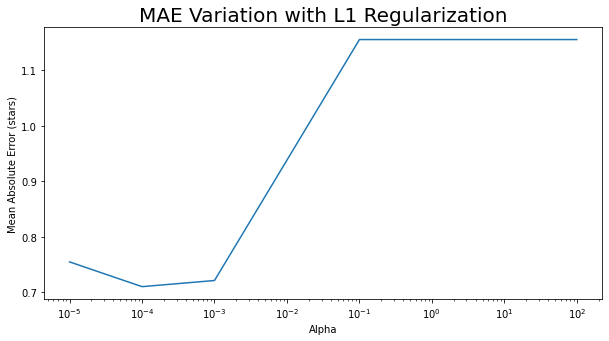

In [54]:
plt.figure(figsize=(10,5))
plt.plot(scores['alpha'], scores['MAE'])
plt.title('MAE Variation with L1 Regularization', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (stars)')
plt.xscale('log')
plt.show()

We can see that we have the lowest mean absolute error at $\alpha$ = $10^{-4}$. Let's fit it to the train set and score both train and test sets.

In [55]:
%%time

lasso_linreg_pipeline = Pipeline([
    ('col_trans', bow_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Lasso(alpha=10**(-4)))
])

lasso_linreg_pipeline.fit(X_train, y_train)

CPU times: user 32.1 s, sys: 9.94 s, total: 42.1 s
Wall time: 13.6 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month',
                                                   'Day of Week', 'Hour',
                                                   'latitude', 'longitude',
                                                   'average_rating', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
      

In [56]:
model_results(lasso_linreg_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.57 stars
R^2 on train set 0.7


MAE on test set: 0.71 stars
R^2 on test set: 0.54


The result for both train and test sets with Lasso Regularization is the same as what we had for Ridge Regularization. 

Note that we have only defined pipelines thus far that use a Bag of Words with lemmatization vectorizer, hence we need to try our other vectorizers with the same model.s

Now that we have got a sense of candidate $\alpha$ values for both Ridge and Lasso Regularization, we will now use `GridSearchCV` from Scikit-Learn to evaluate the best candidate of different combinations of linear regression ($l_1$, $l_2$, or no regulairzation), our 4 vectorizer types, and range of promising $\alpha$ values.

Note that grid search parameter `refit` has been set to our `custom_mae_scorer`.

#### Model 1: GridSearchCV for Vectorizer, Model and Hyperparamter Tuning

In [57]:
linreg_pipeline = Pipeline([
    ('col_trans', bow_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Ridge())
])


param_grid = [
                {
                    'model': [LinearRegression()],
                    'col_trans': vectorizer_list # try all 4 vectorizers
                },
                {
                    'model': [Ridge()],
                    'col_trans': vectorizer_list,
                    'model__alpha': [1, 5, 10] # promising alpha values for Ridge
                },
                {
                    'model': [Lasso()],
                    'col_trans': vectorizer_list,
                    'model__alpha': [0.00001, 0.0001, 0.001] # promising alpha values for Lasso
                }] 


linreg_grid_search = GridSearchCV(linreg_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4, n_jobs=-2)

**NOTE the code block below took ~11 minutes to run. To avoid refitting the search, the main features (best parameters, estimator, score, results) of the fitted search have been pickled and loaded into separate variables in the cell. To refit the search, change `lin_reg_grid_search_exists_flag` to 0 and refit the search. Note this will overwrite the existing fitted search feature pickle files.**

In [58]:
%%time

# set flag to 0 if model re-fitting is desired
lin_reg_grid_search_exists_flag = 1

if lin_reg_grid_search_exists_flag:
    
    linreg_grid_search_params = joblib.load('linreg_grid_search_params.pkl')
    best_linreg_pipeline = joblib.load('linreg_grid_search_params.pkl')
    linreg_grid_search_score = joblib.load('linreg_grid_search_score.pkl')
    linreg_grid_search_results = joblib.load('linreg_grid_search_results.pkl') 
    
else:
    # Fit the search
    linreg_grid_search.fit(X_train, y_train)
    
    # Save fitted grid search features
    linreg_grid_search_params = linreg_grid_search.best_params_
    joblib.dump(linreg_grid_search_params, 'linreg_grid_search_params.pkl')

    best_linreg_pipeline = linreg_grid_search.best_estimator_
    joblib.dump(linreg_grid_search_params, 'linreg_grid_search_estimator.pkl')

    linreg_grid_search_score = linreg_grid_search.best_score_
    joblib.dump(linreg_grid_search_score, 'linreg_grid_search_score.pkl')

    linreg_grid_search_results = linreg_grid_search.cv_results_
    joblib.dump(linreg_grid_search_results, 'linreg_grid_search_results.pkl')

CPU times: user 62.4 ms, sys: 11 ms, total: 73.4 ms
Wall time: 7.72 ms


Let's look at the best parameters found by our search.

In [59]:
linreg_grid_search_params

{'col_trans': ColumnTransformer(transformers=[('numeric', 'passthrough',
                                  ['Year', 'Month', 'Day of Week', 'Hour',
                                   'latitude', 'longitude', 'average_rating',
                                   'is_open', 'RestaurantsGoodForGroups',
                                   'HasTV', 'GoodForKids', 'RestaurantsTakeOut',
                                   'RestaurantsPriceRange2',
                                   'RestaurantsReservations',
                                   'RestaurantsDelivery', 'OutdoorSeating',
                                   'NoiseLevel', 'BusinessAcceptsCreditCards',
                                   'Sandwiches', 'Pizza', 'Bars',
                                   'American (Traditional)', 'American (New)',
                                   'Italian', 'Breakfast & Brunch',
                                   'Coffee & Tea', 'Chinese', 'Seafood',
                                   'Burgers', 'Fast Foo

In [60]:
-linreg_grid_search_score

0.635594616394194

The best pipeline returned by the Linear Regression Grid Search was a TF-IDF Vectorizer with stemming with a Ridge Regression model and an $\alpha$ value of 10. The mean MAE was 0.64. 

Before fitting this model to our train set, let's take a look at some plots to see how the other vectorizers faired. We first build a data frame of all the scores.

In [61]:
temp_df = pd.DataFrame(columns=['Regularization', 'Vectorizer', 'Alpha', 'MAE', 'R2'])

for item in linreg_grid_search_results['params']:
    
    # get index of search result parameter
    i = linreg_grid_search_results['params'].index(item)
    
    
    if type(item['model']) == Ridge:
        reg_type = 'L2 Regularization'
        
    elif type(item['model']) == Lasso:
        reg_type = 'L1 Regularization'
    
    else:
        reg_type = 'No Regularization'
    
    vectorizer = item['col_trans'].get_params()['transformers'][1][0]
    
    if reg_type == 'No Regularization':
        alpha = 0
    
    else:
        alpha = item['model__alpha']
    
    temp_df = temp_df.append({'Regularization': reg_type,
                              'Vectorizer': vectorizer,
                              'Alpha': alpha,
                              'MAE': -linreg_grid_search_results['mean_test_custom_mae_scorer'][i],
                              'R2': linreg_grid_search_results['mean_test_custom_r2_scorer'][i]},
                             ignore_index=True)
    
temp_df
        

,Regularization,Vectorizer,Alpha,MAE,R2
0,No Regularization,bow_stem_ct,0,0.769866,0.447702
1,No Regularization,bow_lem_ct,0,0.764292,0.456506
2,No Regularization,tfidf_stem_ct,0,0.684717,0.557196
3,No Regularization,tfidf_lem_ct,0,0.682787,0.558696
4,L2 Regularization,bow_stem_ct,1,0.731048,0.510246
5,L2 Regularization,bow_stem_ct,5,0.704438,0.555360
6,L2 Regularization,bow_stem_ct,10,0.701963,0.563667
7,L2 Regularization,bow_lem_ct,1,0.728962,0.513855
8,L2 Regularization,bow_lem_ct,5,0.703399,0.555845
9,L2 Regularization,bow_lem_ct,10,0.701749,0.563140


In [62]:
# Define a dictionary to map column transformer names to meaningful descriptions and colors for plotting

vectorizer_dict = {'bow_stem_ct': {'descriptor': 'Bag of Words with Stemming', 'color': 'cornflowerblue'},
                   'bow_lem_ct': {'descriptor': 'Bag of Words with Lemmatization', 'color': 'lightsteelblue'},
                   'tfidf_stem_ct': {'descriptor': 'TF-IDF with Stemming', 'color': 'red'},
                   'tfidf_lem_ct': {'descriptor': 'TF-IDF with Lemmatization', 'color': 'pink'},
                   'sent2vec': {'descriptor': 'Word Embeddings','color': 'black'}}

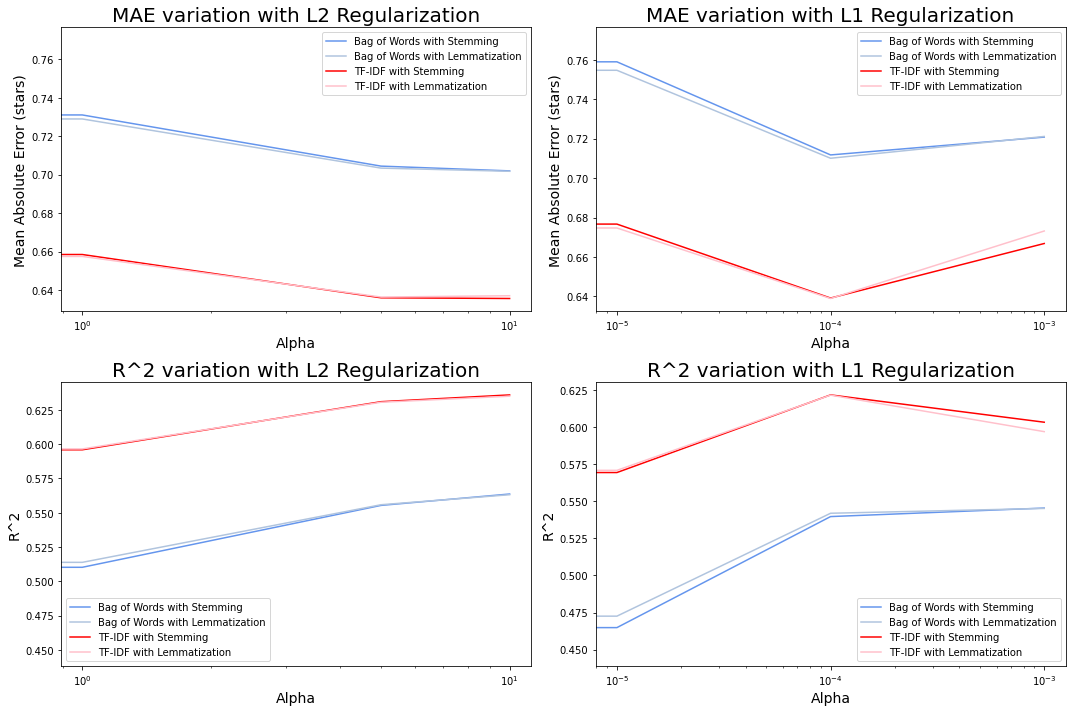

In [63]:
plt.subplots(2, 2, figsize=(15,10))

l2_df = temp_df[temp_df['Regularization'].isin(['No Regularization', 'L2 Regularization'])]

# Plot L2 Regularization MAE scores
plt.subplot(2, 2, 1)
for vectorizer in l2_df['Vectorizer'].unique():
    vect_df = l2_df[l2_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('MAE variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()

# Plot L2 reg R^2 scores
plt.subplot(2, 2, 3)
for vectorizer in l2_df['Vectorizer'].unique():
    vect_df = l2_df[l2_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('R^2 variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()

# plot L1 Reg MAE scores
plt.subplot(2, 2, 2)
l1_df = temp_df[temp_df['Regularization'].isin(['No Regularization', 'L1 Regularization'])]

for vectorizer in l1_df['Vectorizer'].unique():
    vect_df = l1_df[l1_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('MAE variation with L1 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()

# plot L1 Reg R^2 scores
plt.subplot(2, 2, 4)
for vectorizer in l1_df['Vectorizer'].unique():
    vect_df = l1_df[l1_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('R^2 variation with L1 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()


plt.tight_layout()
plt.show()

We can see that for both models, TF-IDF produces the lowest error and better fit compared to Bag of Words. Also worth noting, that for TF-IDF, while stemming produced the lowest error, the difference between stemming and lemmatization is extremely small (a difference of just 0.001 stars).

#### Model 1: Tuned Model Evaluation

Now that we have tuned our pipeline's column transformer and model hyperparameters, we can now train it on the full training set and evaluate it on the test set.

**NOTE: It may take some time to fit the model below. To avoid refitting the model, a fitted model has been pickled and is loaded in the cell. To refit the model, change `best_linreg_exists_flag` to 0 and refit the model. Note this will overwrite the existing fitted model pickle file.**

In [64]:
%%time

# set flag to 0 if model re-fitting is desired
best_linreg_exists_flag = 1

if best_linreg_exists_flag:
    # load the already trained model
    best_linreg_pipeline = joblib.load('best_linreg_pipeline.pkl')
    
else:
    # fit the model
    best_linreg_pipeline.fit(X_train, y_train)

    # Save the model as pickle file
    joblib.dump(best_linreg_pipeline, 'best_linreg_pipeline.pkl')

CPU times: user 741 ms, sys: 24.7 ms, total: 766 ms
Wall time: 768 ms


MAE on train set: 0.54 stars
R^2 on train set 0.74


MAE on test set: 0.65 stars
R^2 on test set: 0.62


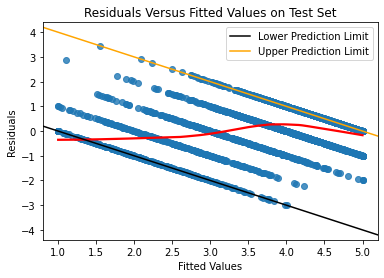

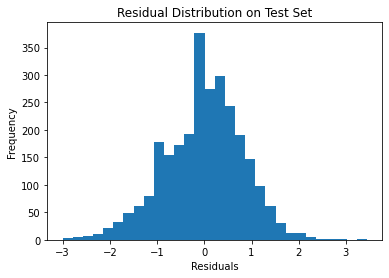

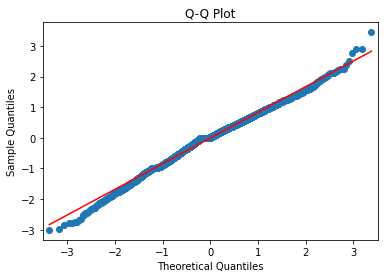

In [226]:
model_results(best_linreg_pipeline, X_train, y_train, X_test, y_test, show_plots=True)

Our mean absolute error on the train set is 0.54 stars, while the test set has a mean absolute error of 0.65 stars. Our $R^{2}$ values on the train and test sets are 0.74 and 0.62 respectively. Hence our optimized linear regression model explains 62% of the ratings in the test set.

We can also see that our residual scatter plot that the residuals do not follow a trend across the range of predictions, which indicates homoscedasticity. Note that the tapered corners of the residuals is due to the `bound_predict` method which limits predictions to within a range of 1 and 5 as indicated by the legend - for example, it is not possible to have a prediction of 1 and an error less than 0 since our minimum possible rating score is 1, hence in this case the minimum possible residual value for a prediction of 1 is 0. Homoscedacity allows the the standard errors (SE) for the calculated regression coefficients to more likely be correct. It also means that tests of coefficient significance (and other tests related to a regression model) can be trusted as they use the standard errors in the denominator when calculating the test statistic. 

The histogram of the residuals and the Q-Q plots indicates that our residuals are normally distributed, which is a key assumption of linear regression models.

Overall, we have a good quality linear regression model. We will save the result to our results data frame.

In [218]:
overall_results_df = overall_results_df.append({'model': 'Ridge Regression',
                            'vectorizer': 'TF-IDF with Stemming',
                            'MAE': custom_mae_scorer_func(y_test, best_linreg_pipeline.predict(X_test)),
                            'R-squared': custom_r2_scorer_func(y_test, best_linreg_pipeline.predict(X_test))},
                            ignore_index=True)

overall_results_df

,model,vectorizer,MAE,R-squared
0,Ridge Regression,TF-IDF with Stemming,0.646668,0.623603
1,XGBoost,TF-IDF with Stemming,0.660923,0.599714
2,Mean Predictor,N/A,1.155734,0.000000
3,Ridge Regression,TF-IDF with Stemming,0.646668,0.623603


#### Model 1: Most Important Features

Having optimized our Linear Regression model, we will take a look at the most important features in our model, by extracting the top 20 and lowest 20 coefficients of our model.

In [103]:
coef_df = pd.DataFrame({'feature': best_linreg_pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'coefficient': best_linreg_pipeline.named_steps['model'].coef_}).\
                        sort_values("coefficient", ascending=False)
coef_df.head()

,feature,coefficient
202,tfidf_stem_ct__amaz,1.427049
6,numeric__average_rating,1.311256
345,tfidf_stem_ct__best,1.273852
774,tfidf_stem_ct__delici,0.954807
1651,tfidf_stem_ct__love,0.897330


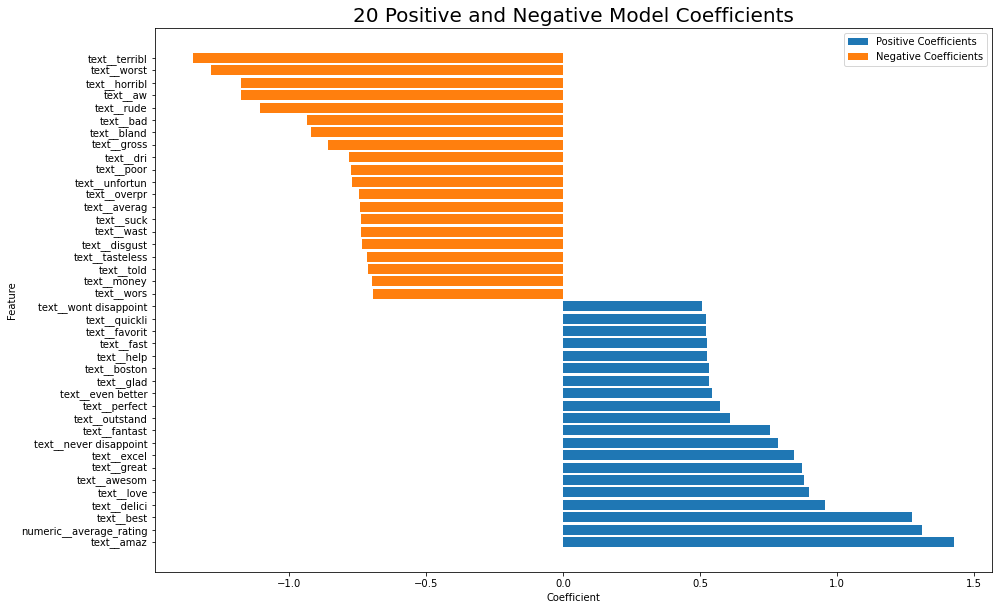

In [109]:
plt.figure(figsize=(15,10))
plt.title('20 Positive and Negative Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(coef_df['feature'].str.replace('tfidf_stem_ct', 'text').head(20), coef_df['coefficient'].head(20), label='Positive Coefficients')
plt.barh(coef_df['feature'].str.replace('tfidf_stem_ct', 'text').tail(20), coef_df['coefficient'].tail(20), label='Negative Coefficients')
plt.legend()
plt.show()

From the plot above, we see that the top 20 positive coefficients and top 20 negative coefficients comprise almost entirely of tokens from the text review, with the existing average rating of the restaurant being the only numeric feature to make the top 20 (it is the second highest positive coefficient value). This indicates that the customer experience at the restaurant outweighs the amenities that the restaurant might have. Let's look at the text and numeric features separately.

In [114]:
## Extract only the text features econded by the vectorizer

review_coef_df = coef_df[coef_df['feature'].str.contains('tfidf_stem_ct__')]
review_coef_df.head()

,feature,coefficient
202,tfidf_stem_ct__amaz,1.427049
345,tfidf_stem_ct__best,1.273852
774,tfidf_stem_ct__delici,0.954807
1651,tfidf_stem_ct__love,0.897330
278,tfidf_stem_ct__awesom,0.881622


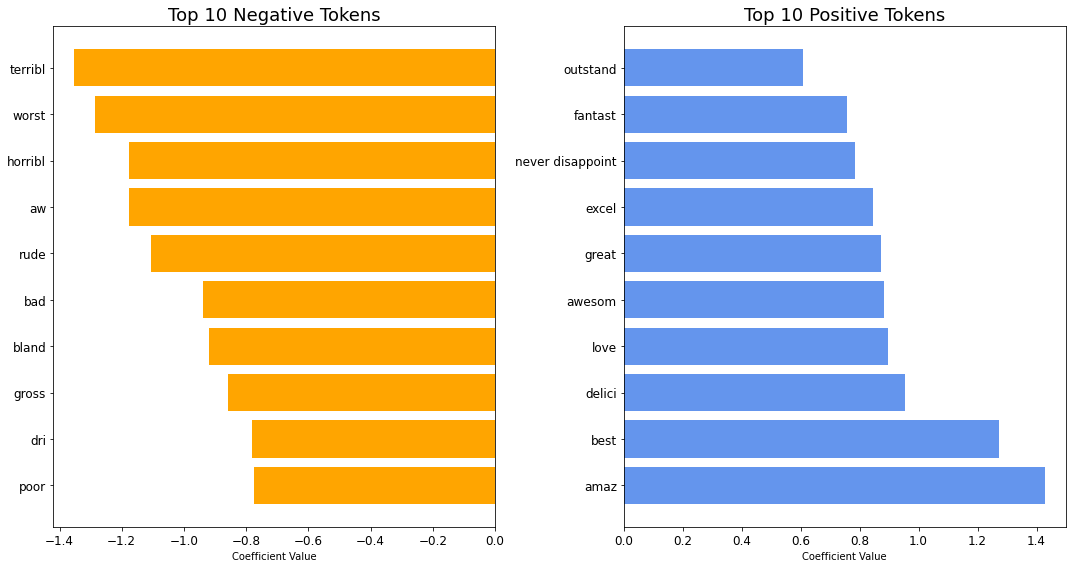

In [234]:
plt.subplots(1,2, figsize=(15,8))
# plt.title('Top 20 Most Positive and Negative Tokens By Coefficient Value', fontsize=20)
# plt.xlabel('Coefficient')
# plt.ylabel('Token')

plt.subplot(1,2,2)
plt.title('Top 10 Positive Tokens', fontsize=18)
plt.xlabel('Coefficient Value')
plt.barh(review_coef_df['feature'].str.replace('tfidf_stem_ct__', '').head(10),
         review_coef_df.head(10)["coefficient"], label='Positive Coefficients', color='cornflowerblue')
plt.tick_params(labelsize='large')

plt.subplot(1,2,1)
plt.title('Top 10 Negative Tokens', fontsize=18)
plt.xlabel('Coefficient Value')
plt.barh(review_coef_df['feature'].str.replace('tfidf_stem_ct__', '').tail(10),
         review_coef_df.tail(10)["coefficient"], label='Negative Coefficients', color='orange')
plt.tick_params(labelsize='large')

plt.tight_layout()
plt.savefig('word_coefficients.png', dpi=150)
plt.show()

We can see that the most positive words in the dataframe include descriptive adjectives, like 'amazing', 'best', 'delicious', 'love' and 'awesome'. The top negative words are also adjectives like 'terrible', 'worst', 'horrible', 'awful', 'rude' and 'bad'.


Some bigram tokens appeared in the top 20 positive features as well, namely 'never disappoint', 'wont disappoint' and 'go wrong', indicating that the sequence of words in a review plays a role in driving sentiment. Let's take a look at some reviews that contain the highest coefficient bigram, 'never disappoint'.

In [202]:

feature = 'never disappoint'

### Look at first 
for review in X_test[X_test['text'].str.contains(feature)]['text'].head(3).unique():
    i = X_test.index[X_test['text'] == review].values[0]
    print(X_test.loc[i, 'text'])
    print('\n')
    print(f"Review rating: {y_test[i]}")
    print('##########################')
    print('\n')

Theo's is my favorite breakfast spot in the North End! I've been coming here for 4 years for breakfast and it's never disappointed. I love their pancakes, waffles, blueberry muffins, home fries & eggs. Most recently, I've been ordering their acai bowl- they make it with acai berry, fresh bananas & strawberries, granola, and a little guarana syrup on top. Delicious!! The name describes it perfectly- it is a "cozy" little restaurant with 6 or so tables and a breakfast bar seating for probably 8 or 9 more people. Cash only so make sure you stop at ATM on the way before visiting this little gem!


Review rating: 5
##########################


Oh God, Sabatino's, I order from you at least once a week and you never disappoint. 
This is literally the only good pizza I've had since moving to Boston.  It's amazing and about as close to NYC pizza as I'll probably get here.  I've ordered the pasta dishes and they're delicious as well--and HUGE.  I usually order the mushroom ravioli and it's enoug

In [186]:
feature = ' fast '

### Look at first 
for review in X_test[X_test['text'].str.contains(feature)]['text'].head(3).unique():
    i = X_test.index[X_test['text'] == review].values[0]
    print(X_test.loc[i, 'text'])
    print('\n')
    print(f"Review rating: {y_test[i]}")
    print('##########################')
    print('\n')

Long overdue for posting this review as I've been a fan and frequenter of Florina since day one.  No need for a long winded story here--hands down best fast causal pizza and quick but gourmet serve Italian in the city. And by "the city" I don't mean New York you ignoramus. I mean Boston. The real city.


Review rating: 5
##########################


This place was a SURPRISE. It looks cheap, it looks tacky, it might scare you and make you want to go out, BUT DONT, go in. I came here with a Friend shortly after I moved into my new Allston apartment for the summer for some cheap good eats. Le's did everything I wanted. It was cheap, authentic, and fresh. 

We started with some dumplings which were delicious and fresh tasting and came with a nice sauce. I got the lemongrass chicken which was different than anything I ever had but very tasty. Tender pieces of chicken in a spicy, lemongrass infused peanut sauce served with tasty rice, it was very good. My Friend got the pho, which I have ha

We can see that these reviews all have a score of 5 stars, and contain very positive experiences at the restaurants. Hence the model was able to detect that having a negating word like 'never' in front of negative word like 'disappoint' in a sentence indicates a positive experience.

In [128]:
list_of_positive_words = review_coef_df['feature'].head(20).\
                    drop(['tfidf_stem_ct__quickli', 'tfidf_stem_ct__wont disappoint'],axis=0).unique()


for feature in review_coef_df['feature'].head(20).unique():
    feature = feature.replace('tfidf_stem_ct__', '')
    count = X_train[X_train['text'].str.contains(feature)]['text'].count()
    avg_rating = y_train[X_train['text'].str.contains(feature)].mean()
    print(f'Token: "{feature}" present in {count} reviews. Average rating of these reviews: {avg_rating}')

Token: "amaz" present in 1095 reviews. Average rating of these reviews: 4.4100456621004565
Token: "best" present in 1569 reviews. Average rating of these reviews: 4.08540471637986
Token: "delici" present in 1802 reviews. Average rating of these reviews: 4.365704772475028
Token: "love" present in 1702 reviews. Average rating of these reviews: 4.082256169212691
Token: "awesom" present in 563 reviews. Average rating of these reviews: 4.33214920071048
Token: "great" present in 3023 reviews. Average rating of these reviews: 4.051604366523321
Token: "excel" present in 643 reviews. Average rating of these reviews: 4.172628304821151
Token: "never disappoint" present in 39 reviews. Average rating of these reviews: 4.615384615384615
Token: "fantast" present in 403 reviews. Average rating of these reviews: 4.444168734491315
Token: "outstand" present in 137 reviews. Average rating of these reviews: 4.386861313868613
Token: "perfect" present in 972 reviews. Average rating of these reviews: 4.346707

In [119]:
X_train[X_train['text'].str.contains('never disappoint')]['text'].count()

39

In [176]:
remaining_coef_df = coef_df[coef_df['feature'].str.contains('numeric__')]
remaining_coef_df.head()

,feature,coefficient
6,numeric__average_rating,1.311256
37,numeric__repeat_customers,0.107998
5,numeric__longitude,0.103071
29,numeric__Fast Food,0.058323
10,numeric__GoodForKids,0.049638


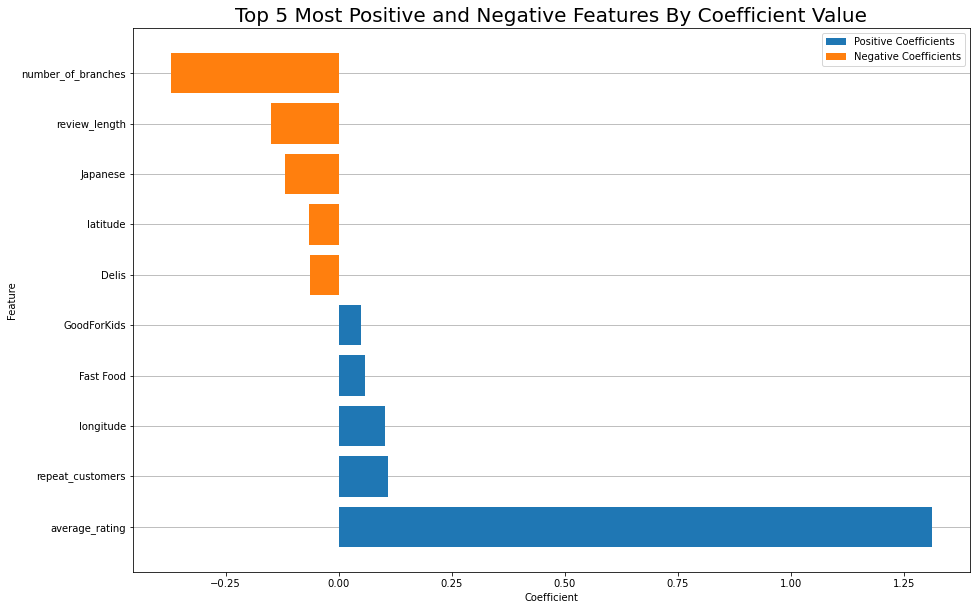

In [183]:
plt.figure(figsize=(15,10))
plt.title('Top 5 Most Positive and Negative Features By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(remaining_coef_df['feature'].str.replace('numeric__', '').head(5),
         remaining_coef_df.head(5)["coefficient"], label='Positive Coefficients')
plt.barh(remaining_coef_df['feature'].str.replace('numeric__', '').tail(5),
         remaining_coef_df.tail(5)["coefficient"], label='Negative Coefficients')
plt.legend()
axes = plt.gca()
axes.set_axisbelow(True)
axes.yaxis.grid()
plt.savefig('attribute_coefficients.png', dpi=300)

plt.show()

### Model 2: Decision Tree Regression

We now explore our second model type, which is Decision Tree Regression. Decision Trees have a few more hyperparameters that can be tuned. Keeping the default parameters from Scitkit-Learn's `DecisionTreeRegressor` is likely to lead to overfitting on the training set. We will use a TF-IDF vectorzier pipeline under K-Fold cross validation, varying the following hyperparameters:
- `max_depth`: the maximum depth of the tree
- `max_features`: the number of features to consider when looking for the best split. If a float is provided, then `max_features` is a fraction and of the total features that will be considered at each split

We will hold `min_samples_leaf` constant to maintain a decent minimum number of samples at a leaf node, again in an attempt to minimize overfitting.

**NOTE the code block below took 35 minutes to run. Hence a pickle file of a data frame with the cross validation scores for each  hyperparameter combination has been loaded. If refitting the model is desired, set `DT_flag` to 0.**

In [72]:
%%time

# set flag to 0 if model fitting is desired
DT_flag = 1

if DT_flag == 1:
    scores = joblib.load('DT_scores.pkl')
    
else:

    scores = pd.DataFrame(columns=['max_depth', 'max_features', 'MAE', 'R-squared'])
    
    pipeline = Pipeline([
        ('col_trans', tfidf_stem_ct),
        ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('model', DecisionTreeRegressor(min_samples_leaf=4,random_state=0))
    ])

    for max_depth in [5, 10, 15, 20, 25, 30]:

        for max_features in [0.25, 0.5, 0.75, 1.0]:

            cv_scores = cross_validate(pipeline.set_params(**{'model__max_depth': max_depth,
                                                              'model__max_features': max_features}),
                                       X_train, y_train, cv=5,
                                       scoring=scorer)

            scores = scores.append({'max_depth': max_depth, 'max_features': max_features,
                                            'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                            'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])},
                                   ignore_index=True)
            
    joblib.dump(scores, 'DT_scores.pkl')
    
    
scores

CPU times: user 909 µs, sys: 700 µs, total: 1.61 ms
Wall time: 1.58 ms


,max_depth,max_features,MAE,R-squared
0,5.0,0.25,0.956450,0.224880
1,5.0,0.50,0.951338,0.241202
2,5.0,0.75,0.941126,0.249675
3,5.0,1.00,0.936784,0.256804
4,10.0,0.25,0.884848,0.295650
5,10.0,0.50,0.887376,0.301061
6,10.0,0.75,0.887782,0.290835
7,10.0,1.00,0.896709,0.279221
8,15.0,0.25,0.859606,0.302317
9,15.0,0.50,0.862927,0.287892


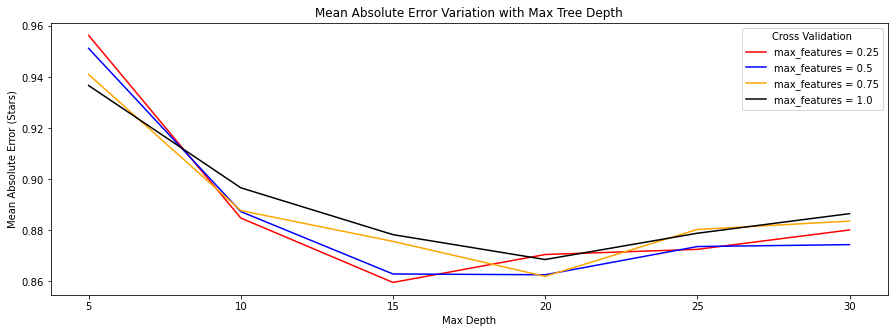

In [73]:
plt.figure(figsize=(15,5))

colors = ['red', 'blue', 'orange', 'black']

i=0
for max_features in scores['max_features'].unique():
    temp_df = scores[scores['max_features'] == max_features]
    plt.plot(temp_df['max_depth'], temp_df['MAE'], label='max_features = ' + str(max_features),
             color=colors[i])
    i += 1

plt.legend(title='Cross Validation')
plt.title('Mean Absolute Error Variation with Max Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Absolute Error (Stars)')
plt.plot()
plt.show()

The plot above shows that the lowest MAE is achieved at a maximum depth of 15, with a maximum features fraction of 0.25. At depths greater than 15, the cross validation score increases suggesting overfitting since we are using cross-validation.

In [74]:
%%time

DT_pipeline = Pipeline([
    ('col_trans', tfidf_stem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', DecisionTreeRegressor(min_samples_leaf=4, random_state=0, 
                                   max_depth=15, max_features=0.25))
])

DT_pipeline.fit(X_train, y_train)

CPU times: user 16.9 s, sys: 276 ms, total: 17.2 s
Wall time: 17.1 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month',
                                                   'Day of Week', 'Hour',
                                                   'latitude', 'longitude',
                                                   'average_rating', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
      

In [75]:
model_results(DT_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.69 stars
R^2 on train set 0.54


MAE on test set: 0.88 stars
R^2 on test set: 0.28


Despite selecting hyperparameters via cross-validation, our scores on our test set are quite disappointing, with a MAE of 0.88 stars and $R^{2}$ of 0.28. There is a noticeable difference between the test set scores and the train set scores, suggesting that the decision tree is overfitting to the train set. 

#### Model 2: Pipeline and Model Optimization Search

We now use `GridSearchCV` with decision tree to pick our best hyperparameter and vectorizer combination, similar to the way we did for Linear Regression models.

In [203]:
DT_pipeline = Pipeline([
    ('col_trans', bow_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', DecisionTreeRegressor())
])


param_grid = [
                {
                    'model__max_depth': [15, 18, 20],
                    'model__max_features': [0.5, 0.75, 1],
                    'model__min_samples_leaf': [4, 6],
                    'model__random_state': [0],
                    'col_trans': vectorizer_list
                }] 

DT_grid_search = GridSearchCV(DT_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=1, n_jobs=-2)

**NOTE the code block below took ~25 minutes to run. To avoid refitting the search, the main features (best parameters, estimator, score, results) of the fitted search have been pickled and loaded into separate variables in the cell. To refit the search, change `DT_grid_search_exists_flag` to 0 and refit the search. Note this will overwrite the existing fitted search feature pickle files.**

In [209]:
%%time

# set flag to 0 if search re-fitting is desired
DT_grid_search_exists_flag = 1

if DT_grid_search_exists_flag == 1:
    DT_grid_search_params = joblib.load('DT_grid_search_params.pkl')
    best_DT_pipeline = joblib.load('DT_grid_search_estimator.pkl')
    DT_grid_search_score = joblib.load('DT_grid_search_score.pkl')
    DT_grid_search_results = joblib.load('DT_grid_search_results.pkl')
    
else:
    
    # Fit the search
    DT_grid_search.fit(X_train, y_train)
    
    # Save fitted grid search parameters
    DT_grid_search_params = DT_grid_search.best_params_
    joblib.dump(DT_grid_search_params, 'DT_grid_search_params.pkl')

    best_DT_pipeline = DT_grid_search.best_estimator_
    joblib.dump(best_DT_pipeline, 'DT_grid_search_estimator.pkl')

    DT_grid_search_score = DT_grid_search.best_score_
    joblib.dump(DT_grid_search_score, 'DT_grid_search_score.pkl')

    DT_grid_search_results = DT_grid_search.cv_results_
    joblib.dump(DT_grid_search_results, 'DT_grid_search_results.pkl')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 1min 20s, sys: 12.1 s, total: 1min 32s
Wall time: 17min 44s


In [210]:
DT_grid_search_score

-0.8573093093392135

In [211]:
DT_grid_search_params

{'col_trans': ColumnTransformer(transformers=[('numeric', 'passthrough',
                                  ['Year', 'Month', 'Day of Week', 'Hour',
                                   'latitude', 'longitude', 'average_rating',
                                   'is_open', 'RestaurantsGoodForGroups',
                                   'HasTV', 'GoodForKids', 'RestaurantsTakeOut',
                                   'RestaurantsPriceRange2',
                                   'RestaurantsReservations',
                                   'RestaurantsDelivery', 'OutdoorSeating',
                                   'NoiseLevel', 'BusinessAcceptsCreditCards',
                                   'Sandwiches', 'Pizza', 'Bars',
                                   'American (Traditional)', 'American (New)',
                                   'Italian', 'Breakfast & Brunch',
                                   'Coffee & Tea', 'Chinese', 'Seafood',
                                   'Burgers', 'Fast Foo

In [212]:
%%time

# set flag to 0 if model re-fitting is desired
best_DT_exists_flag = 0

if best_DT_exists_flag:
    # load the already trained model
    best_DT_pipeline = joblib.load('best_DT_pipeline.pkl')
    
else:
    # fit the model
    best_DT_pipeline.fit(X_train, y_train)

    # Save the model as pickle file
    joblib.dump(best_DT_pipeline, 'best_DT_pipeline.pkl')

CPU times: user 19 s, sys: 212 ms, total: 19.2 s
Wall time: 19.3 s


MAE on train set: 0.58 stars
R^2 on train set 0.64


MAE on test set: 0.9 stars
R^2 on test set: 0.21


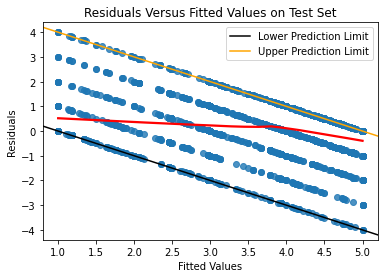

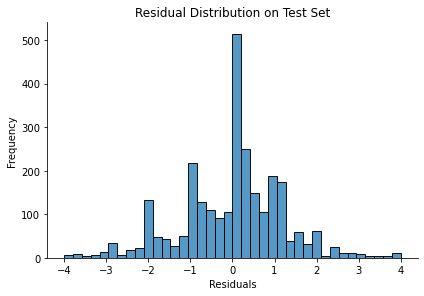

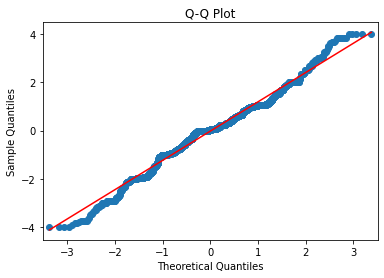

In [213]:
model_results(best_DT_pipeline, X_train, y_train, X_test, y_test, show_plots=True)

### Model 4: XGBoost Regressor

For our next model, we will explore a gradient boosting model. Specifically, we will explore the XGBoost Regressor, which is an ensemble method.

#### Model 4: Using Optuna to Estimate Best Hyperparameters

Compared to the other models we have explored, XGBoost has a vast variety of hyperparameters that need to be tuned. Also, being an ensemble method, it has a considerably longer run time than Linear Regression or Decision Tree Regression. Before jumping to a `GridSearchCV`, we will use Optuna to pick a set of hyperparameters from a range of choices, but limiting its search to just 20 trials due to XGBoost's long run time. Due to the model's long run time and time constraints related to this project, and the fact that we only Optuna for a guestimate of promising hyperparameters, we will begin by dividing the training set into a remainder set and validation set rather than using K-fold cross validation. We will then use an Optuna study to fit a pipeline to the training set, giving it a goal of minimizing the MAE on the validation set.

Once we get a set of promising hyperparameters, we can then define a small parameter grid of hyperparameters in close proximity to the values obtained by the Optuna study. These hyperparameters along with the 2 TF-IDF vectorizers (stemming and lemmatization) can then be evaluated in a grid search cross validation study. We will also no longer consider Bag of Words vectorizers as they have performed poorly compared to the TF-IDF vectorizers both for Linear Regression and Decision Tree Regression.

In [82]:
X_rem, X_val, y_rem, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify=y_train, random_state=0)

print(f'Shape of X_rem: {X_rem.shape}. Shape of y_rem: {y_rem.shape}')
print(f'Shape of X_val: {X_val.shape}. Shape of y_val: {y_val.shape}')

Shape of X_rem: (8734, 47). Shape of y_rem: (8734,)
Shape of X_val: (2184, 47). Shape of y_val: (2184,)


In [83]:
xgb_op_pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', XGBRegressor(random_state=0, verbosity=1, n_jobs=-2))
])



def objective(trial):    
      

    model__max_depth = trial.suggest_int('model__max_depth', 4, 15) 
    model__n_estimators = trial.suggest_int('model__n_estimators', 500, 2000)
    model__min_child_weight=trial.suggest_int("model__min_child_weight", 1, 10)
    model__colsample_bytree=trial.suggest_float("model__colsample_bytree", 0.2, 1.0)
    model__subsample=trial.suggest_float("model__subsample", 0.2, 1.0)
    model__reg_lambda = trial.suggest_loguniform('model__reg_lambda', 1e-4, 1e2)
    model__reg_alpha = trial.suggest_loguniform('model__reg_alpha', 1e-4, 1e2)
    model__learning_rate = trial.suggest_loguniform('model__learning_rate', 1e-4, 1e-1)   
    

    params = {
        'model__max_depth': model__max_depth,
        'model__n_estimators': model__n_estimators,
        'model__min_child_weight': model__min_child_weight,
        'model__colsample_bytree': model__colsample_bytree,
        'model__subsample': model__subsample,
        'model__reg_lambda': model__reg_lambda,
        'model__reg_alpha': model__reg_alpha,
        'model__learning_rate': model__learning_rate
    }
    
    xgb_op_pipeline.set_params(**params)
    
    xgb_op_pipeline.fit(X_rem, y_rem)
    fitted_values = xgb_op_pipeline.predict(X_val)
    

    return custom_mae_scorer_func(y_val, fitted_values)

# study = optuna.create_study(direction='minimize')

**NOTE the Optuna study below took ~1.5 hours to run. To avoid refitting the search, the best pipeline found by the search has been pickled and loaded into separate variables in the cell. To refit the search, change `xgb_optuna_exists_flag` to 0 and refit the search. Note this will overwrite the existing pipeline pickle files.**

In [84]:
%%time

# set flag to zero if model fitting is desired
xgb_optuna_exists_flag = 1

if xgb_optuna_exists_flag == 1:
    xgb_op_best_pipeline = joblib.load('xgb_op_best_pipeline.pkl')
    
else:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    
    xgb_op_best_pipeline = xgb_op_pipeline.set_params(**study.best_params)

CPU times: user 1.26 s, sys: 59.1 ms, total: 1.31 s
Wall time: 1.22 s


Let's take a look at the best parameters that our study found.

In [85]:
xgb_op_best_pipeline.get_params()['model'].get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.706187626388276,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.0354841704260794,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 6,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1574,
 'n_jobs': -2,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0.09144245560657592,
 'reg_lambda': 1.2605120991237,
 'scale_pos_weight': 1,
 'subsample': 0.7464848401578941,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}

We now see how this model fairs on the entire train and test set when fitted to the train set only.

**NOTE: It took ~7 mins to fit the XGBoost pipeline below. To avoid refitting the model, a fitted model has been pickled and is loaded in the cell. To refit the model, change `best_xgb_op_exists_flag` to 0 and refit the model. Note this will overwrite the existing fitted model pickle file.**

In [86]:
%%time

# set flag to 0 if model re-fitting is desired
best_xgb_op_exists_flag = 1

if best_xgb_op_exists_flag:
    # load already trained model
    xgb_op_best_pipeline = joblib.load('xgb_op_best_pipeline.pkl')

else:
    # Fit the model
    xgb_op_best_pipeline.fit(X_train, y_train)
    joblib.dump(xgb_op_best_pipeline, 'xgb_op_best_pipeline.pkl')

CPU times: user 1.26 s, sys: 47.3 ms, total: 1.31 s
Wall time: 1.32 s


In [87]:
model_results(xgb_op_best_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.31 stars
R^2 on train set 0.91


MAE on test set: 0.65 stars
R^2 on test set: 0.61


The MAE is 0.31 stars and 0.65 stars for the train and test sets, while the $R^{2}$ is 0.91 and 0.61 on train and test sets. We can see that while we have reduced the test set error significantly compared to decision tree regression, we are still overfitting to our train set.

In [88]:
print(xgb_op_best_pipeline.get_params()['model'].feature_importances_)

[0.00024206 0.00017476 0.00020022 ... 0.00090519 0.00082248 0.00022538]


In [89]:
print(xgb_op_best_pipeline.named_steps['model'].feature_importances_)

[0.00024206 0.00017476 0.00020022 ... 0.00090519 0.00082248 0.00022538]


In [90]:
feature_df = pd.DataFrame({'feature': xgb_op_best_pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'importance': xgb_op_best_pipeline.named_steps['model'].feature_importances_}).\
                        sort_values("importance", ascending=False)
feature_df.head()

,feature,importance
2291,tfidf_lem_ct__rude,0.010899
2678,tfidf_lem_ct__terrible,0.010385
1406,tfidf_lem_ct__horrible,0.010293
2986,tfidf_lem_ct__worst,0.010088
251,tfidf_lem_ct__asked,0.006819


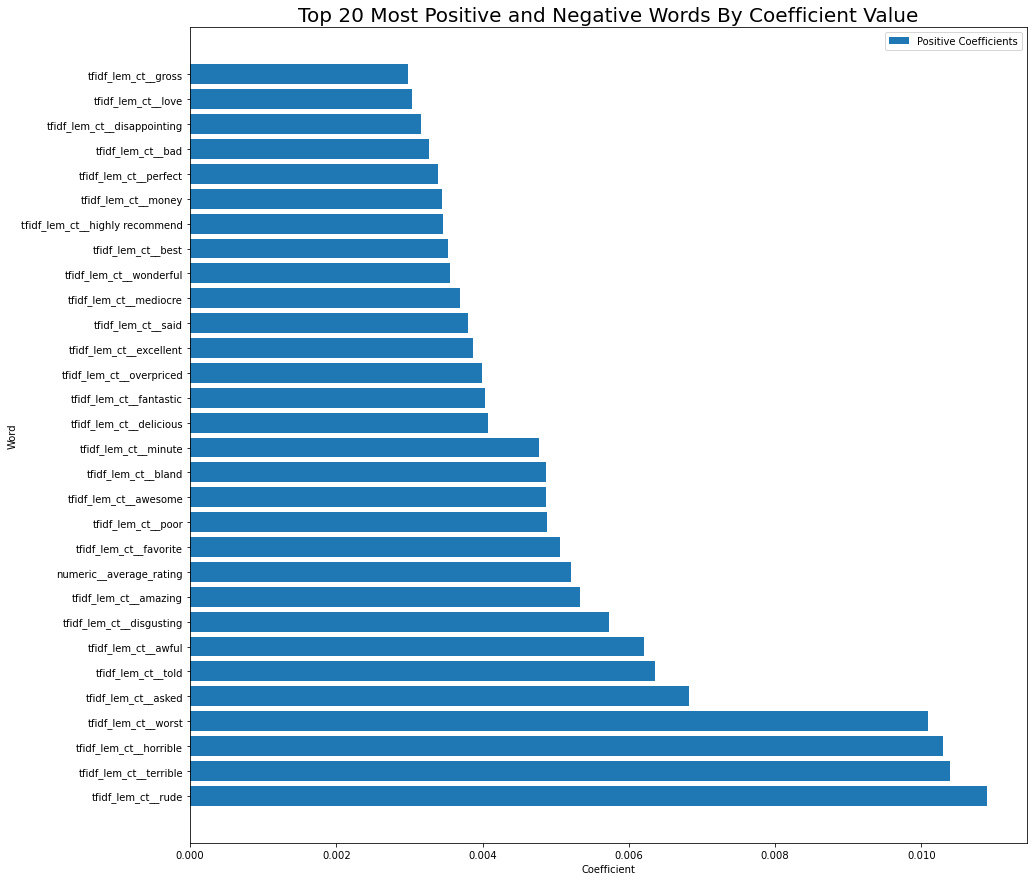

In [91]:
plt.figure(figsize=(15,15))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(feature_df['feature'].str.replace('tfidf_ct__', '').head(30),
         feature_df.head(30)["importance"], label='Positive Coefficients')
plt.legend()

plt.show()

In [92]:
review_feature_df = feature_df[feature_df['feature'].str.contains('tfidf_ct__')]
review_feature_df.head()

,feature,importance


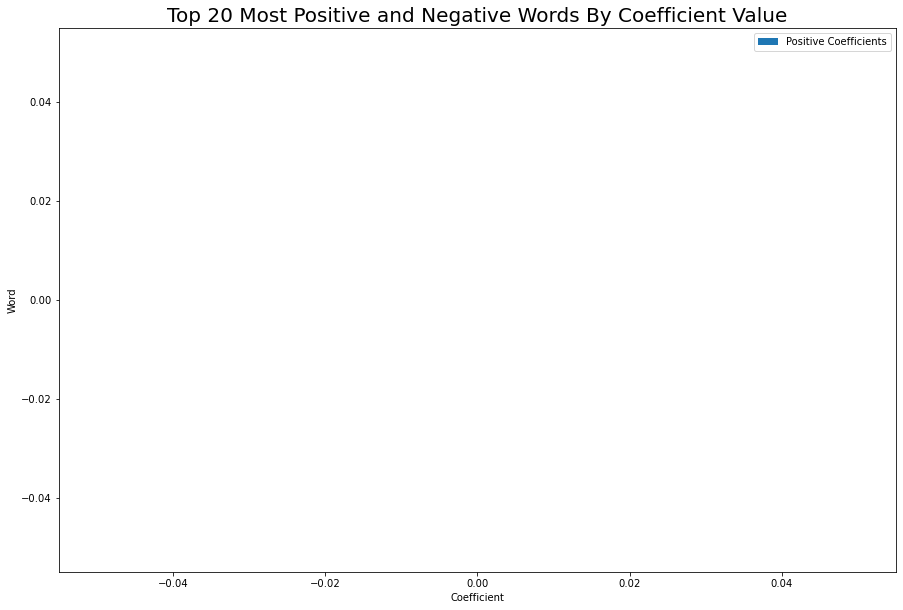

In [93]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(review_feature_df['feature'].str.replace('tfidf_ct__', '').head(30),
         review_feature_df.head(30)["importance"], label='Positive Coefficients')
plt.legend()

plt.show()

#### Model 4: Grid Search

We can now proceed to using GridSearchCV to pick the optimal hyperparameter and vectorizer combination. Since we are using cross validation now, run times will be longer, hence we will only vary the number of estimators and the learning rate for each vectorizer. All other hyperparameters explored with Optuna will be set to the optimal value found by the Optuna study.

In [94]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', XGBRegressor(max_depth=7, min_child_weight=6, colsample_bytree=0.71,
                           reg_lambda=1.3, reg_alpha=0.09, random_state=0, n_jobs=-2))
])

param_grid = [{'col_trans': [tfidf_lem_ct, tfidf_stem_ct],
              'model__n_estimators': [1500],
              'model__learning_rate': [0.1]},
             {'col_trans': [tfidf_lem_ct, tfidf_stem_ct], 
              'model__n_estimators': [2000],
              'model__learning_rate': [0.03]}]

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4)


**NOTE: It took ~2.5 hours to fit the Grid Search below. To avoid refitting the search, the main features (best parameters, estimator, score, results) of the fitted search have been pickled and loaded into separate variables in the cell. To refit the search, change `xgb_grid_search_exists_flag` to 0 and refit the search. Note this will overwrite the existing fitted search feature files pickle file.**

In [95]:
%%time

# set flag to 0 if model re-fitting is desired
xgb_grid_search_exists_flag = 1

if xgb_grid_search_exists_flag == 1:
    
    # Load important features of pre-fitted grid search
    xgb_grid_search_params = joblib.load('xgb_grid_search_params.pkl')
    best_xgb_pipeline = joblib.load('xgb_grid_search_estimator.pkl')
    xgb_grid_search_score = joblib.load('xgb_grid_search_score.pkl')
    xgb_grid_search_results = joblib.load('xgb_grid_search_results.pkl')
    
else:
    
    # Fit the model
    xgb_grid_search.fit(X_train, y_train)
    
    # Save fitted grid search features
    xgb_grid_search_params = xgb_grid_search.best_params_
    joblib.dump(xgb_grid_search_params, 'xgb_grid_search_params.pkl')
    
    best_xgb_pipeline = xgb_grid_search.best_estimator_
    joblib.dump(best_xgb_pipeline, 'xgb_grid_search_estimator.pkl')
    
    xgb_grid_search_score = xgb_grid_search.best_score_
    joblib.dump(xgb_grid_search_score, 'xgb_grid_search_score.pkl')
    
    xgb_grid_search_results = xgb_grid_search.cv_results_
    joblib.dump(xgb_grid_search_results, 'xgb_grid_search_results.pkl')
    

CPU times: user 2.06 s, sys: 71.7 ms, total: 2.13 s
Wall time: 1.95 s


Let's look the parameters found by the grid search.

In [96]:
xgb_grid_search_params

{'col_trans': ColumnTransformer(transformers=[('numeric', 'passthrough',
                                  ['Year', 'Month', 'Day of Week', 'Hour',
                                   'latitude', 'longitude', 'average_rating',
                                   'is_open', 'RestaurantsGoodForGroups',
                                   'HasTV', 'GoodForKids', 'RestaurantsTakeOut',
                                   'RestaurantsPriceRange2',
                                   'RestaurantsReservations',
                                   'RestaurantsDelivery', 'OutdoorSeating',
                                   'NoiseLevel', 'BusinessAcceptsCreditCards',
                                   'Sandwiches', 'Pizza', 'Bars',
                                   'American (Traditional)', 'American (New)',
                                   'Italian', 'Breakfast & Brunch',
                                   'Coffee & Tea', 'Chinese', 'Seafood',
                                   'Burgers', 'Fast Foo

The Grid Search found that TF-IDF vectorizer with stemming, with a model learning rate of 0.03 and 2000 estimators produced the optimal value. Let's fit this model to the train set and evaluate it on the test set.

**NOTE: It took ~10 mins to fit the XGBoost model below. To avoid refitting the model, a fitted model has been pickled and is loaded in the cell. To refit the model, change `best_xgb_exists_flag` to 0 and refit the model. Note this will overwrite the existing fitted model pickle file.**

In [97]:
%%time

# set flag to 0 if model re-fitting is desired
best_xgb_exists_flag = 1

if best_xgb_exists_flag:
    # load the already trained model
    best_xgb_pipeline = joblib.load('best_xgb_pipeline.pkl')
    
else:
    # fit the model
    best_xgb_pipeline.fit(X_train, y_train)

    # Save the model as pickle file
    joblib.dump(best_xgb_pipeline, 'best_xgb_pipeline.pkl')
    


CPU times: user 995 ms, sys: 26.9 ms, total: 1.02 s
Wall time: 1.02 s


MAE on train set: 0.3 stars
R^2 on train set 0.91


MAE on test set: 0.66 stars
R^2 on test set: 0.6


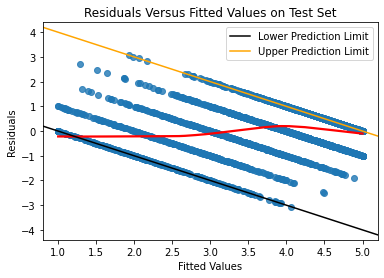

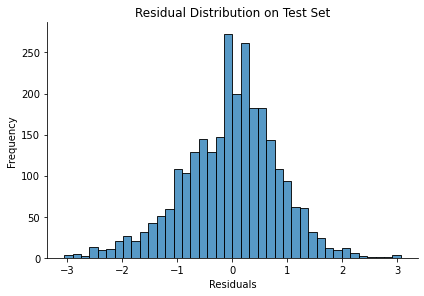

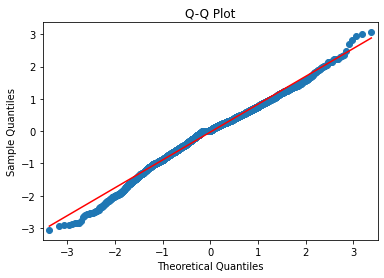

In [98]:
model_results(best_xgb_pipeline, X_train, y_train, X_test, y_test, show_plots=True)

The model produced an MAE of 0.31 stars and 0.66 stars on train and test sets respectively, along with an $R^{2}$ score of 0.91 and 0.6 respectively. This model explains 60% of the variance in the test set ratings. In addition we can see that residuals are again fairly homoscedastic and normally distributed.

In [99]:
overall_results_df

,model,vectorizer,MAE,R-squared
0,Mean Predictor,N/A,1.155734,0.000000
1,Ridge Regression,TF-IDF with Stemming,0.646668,0.623603


In [100]:
overall_results_df = overall_results_df.append({'model': 'XGBoost',
                                               'vectorizer': 'TF-IDF with Stemming',
                    'MAE': custom_mae_scorer_func(y_test, best_xgb_pipeline.predict(X_test)),
                    'R-squared': custom_r2_scorer_func(y_test, best_xgb_pipeline.predict(X_test))},
                                              ignore_index=True)

overall_results_df = overall_results_df.sort_values(by='MAE')

In [101]:
overall_results_df

,model,vectorizer,MAE,R-squared
1,Ridge Regression,TF-IDF with Stemming,0.646668,0.623603
2,XGBoost,TF-IDF with Stemming,0.660923,0.599714
0,Mean Predictor,N/A,1.155734,0.000000
